In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')
#matplotlib.rcParams["figure.facecolor"] = "white"
#matplotlib.rcPar|ams["savefig.transparent"] = "True"


In [2]:
import pandas as pd


from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

from scipy import stats
import os
from efficacy_scripts import *




/home/enf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
from sklearn.preprocessing import scale

In [5]:
from detect_intermediates import *
from interpret_tICs import *

In [6]:
from msmbuilder.utils import verbosedump, verboseload


In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import scale
from random import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [8]:
from get_variable_names import *

In [11]:
from b2ar_feature_types import *
from get_variable_names import *
from b2ar_tica_config import *
from residue import Residue, Atom
ori_feature_name = copy.deepcopy(feature_name)

schemes = ['closest-heavy']
#schemes = ["closest-heavy", "CA"]
feature_name = "%s-py3" %ori_feature_name

rho = 0.01
rho_string = "_rho0pt01"
n_clusters=25
n_samples=5
precision = "XP"
lag_time=5

(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dirdir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/B1AR/featurescontact_6pt6_angstroms-CA-py3-far
/home/enf/md_simulations/B1AR/featurescontact_6pt6_angstroms-CA-py3-far


In [12]:
import os
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

225


<AsyncMapResult: chdir>

In [14]:
bret = pd.read_excel("/home/enf/b2ar_analysis/bret_bias_study2.xlsx", header=0).set_index("EvanName")
bret = bret.iloc[[i for i in range(0,bret.shape[0]) if np.nan_to_num(bret["CID"].values[i]) != 0]]
bret.index = ["CID_%d" %cid for cid in bret["CID"].values]


In [15]:
bouvier=False
if bouvier:
    gprot_col = "cAMP EMAX"
    arr_col = "ERK1/2 EMAX"
else:
    gprot_col = "B2AR-Gprotein, Mean"
    arr_col = "B2AR-Arrestin, Mean"

diff_cutoff = 0.1
abs_cutoff = 0.1
    
def generate_bias_features(bret, gprot_col, arr_col, common_ligands, diff_cutoff=0.3, abs_cutoff=0.2):
    total_activity = bret[arr_col].loc[common_ligands].add(bret[gprot_col].loc[common_ligands])
    #common_agonists = set(bret.loc[bret[arr_col] > abs_cutoff].index.values.tolist()).union(set(bret.loc[bret[gprot_col] > abs_cutoff].index.values.tolist()))
    common_agonists = total_activity.loc[total_activity > abs_cutoff].index.values
    y = np.zeros(len(common_ligands)).reshape((-1,1))
    y_arr = bret[arr_col].loc[common_ligands].values.reshape((-1,1))
    y_gpr = bret[gprot_col].loc[common_ligands].values.reshape((-1,1))
    for idx, lig in enumerate(common_ligands):
        if lig in common_agonists:
            if y_gpr[idx] - y_arr[idx] > diff_cutoff:
                y[idx] = 1.
            else:
                y[idx] = 1.
        else:
            y[idx] = 0.

    y_df = pd.DataFrame(y, index=common_ligands, columns=["class"])
    return y, y_df
total_activity = bret[arr_col].add(bret[gprot_col])

bret_y, bret_y_df = generate_bias_features(bret, gprot_col, arr_col, bret.index,
                                 diff_cutoff=diff_cutoff, abs_cutoff=abs_cutoff)

bret_y_df.loc[[n for n in bret_y_df.index.values if "xam" not in n.lower()]]

,class
CID_7436,1.0
CID_10443654,1.0
CID_161394,0.0
CID_2083,1.0
CID_2119,1.0
CID_2249,0.0
CID_2405,0.0
CID_18026,0.0
CID_5606,1.0
CID_2585,1.0


In [16]:
mehrdad = pd.read_excel("/home/enf/md_simulations/B1AR/docking/mehrdad1.xlsx", header=1)
print(mehrdad.columns.values.tolist())
actions = []
classes = []
labels = mehrdad["Label "].values.tolist()
for i in range(0, mehrdad.shape[0]):
    if "unbiased" in labels[i].lower():
        actions.append("unbiased agonist")
        classes.append(0.)
    elif "biased" in labels[i].lower():
        actions.append("biased agonist")
        classes.append(1.)
    elif "non-binder" in labels[i].lower():
        actions.append("non-binder")
        classes.append(3.)
    elif "antagonist" in labels[i].lower():
        actions.append("antagonist")
        classes.append(3.)
    else:
        actions.append("unknown")
        classes.append(2.)
mehrdad["action"] = actions
mehrdad["class"] = classes

        
#bret = bret.iloc[[i for i in range(0,bret.shape[0]) if np.nan_to_num(bret["CID"].values[i]) != 0]]
#bret.index = ["CID_%d" %cid for cid in bret["CID"].values]



['Name ', 'Label ', 'Emax on G-Protein', 'Emax on B-arrestin', 'Reference ']


In [84]:
import pubchempy as pcp
mehrdad.index = mehrdad["Name "]
new_index = []
for n in mehrdad["Name "].values.tolist():
    cids = pcp.get_cids(n, 'name', 'substance', list_return='flat')
    cids = ["cid_%s" %cid for cid in cids]
    replace=False
    for cid in cids:
        if cid in full_docking_df.index.values:
            replace=True
            new_index.append(cid)
            print(n)
            print(cid)
            break
    if not replace:
        new_index.append(n)
        
        

Isoproterenol
cid_3019
Adrenalone
cid_7436
Epinephrine
cid_838
Fenoterol
cid_3343
Hexoprenaline
cid_3609
Norepinephrine
cid_951
Nebivolol 
cid_313
Bisoprolol 
cid_2405
ICI 118551
cid_3682
CGP 20712A
cid_2685
Betaxolol 
cid_2369
Atenolol
cid_2249
Butaxamine
cid_18026
Labetalol
cid_3869
Practolol
cid_4883
Pronethalol
cid_4930
Propranolol
cid_4946
Sotalol
cid_313
Timolol
cid_5478
donepezil
cid_3152
zolpidem
cid_5732
Diphenhydramine
cid_3100
Ifenprodil
cid_3689
Doxylamine
cid_3162
Oxaprozin
cid_4614
Pirenzepine
cid_4848
Aceclofenac
cid_71771
Acemetacin
cid_1981
Captopril 
cid_2554
Norfloxacin
cid_4539
Cefadroxil 
cid_47964


In [85]:
new_index

['cid_3019',
 'cid_7436',
 'cid_838',
 'cid_3343',
 'cid_3609',
 'cid_951',
 'KSN01-01-4',
 'KSN01-01-7',
 'KSN01-01-8',
 'KSN01-01-14',
 'KSN01-01-15',
 'KSN01-01-26',
 'KS015-02',
 'KS015-04',
 'KS015-09',
 'KS015-15',
 'KS015-01',
 'KS015-03',
 'KS015-06',
 'KS015-07',
 'KS015-10',
 'KS015-11',
 'KSN01-01-18',
 'STD-101-C4',
 'cid_313',
 'cid_2405',
 'cid_3682',
 'cid_2685',
 'cid_2369',
 'cid_2249',
 'cid_18026',
 'cid_3869',
 'cid_4883',
 'cid_4930',
 'cid_4946',
 'cid_313',
 'cid_5478',
 'cid_3152',
 'cid_5732',
 'cid_3100',
 'cid_3689',
 'cid_3162',
 'cid_4614',
 'cid_4848',
 'cid_71771',
 'cid_1981',
 'cid_2554',
 'Sulfadizaine',
 'cid_4539',
 'cid_47964']

In [86]:
mehrdad.index = new_index
mehrdad.index = [n.lower().replace("-", "").replace(" ", "").strip() for n in mehrdad.index.values]

In [225]:
bret_y_df

,class
CID_7436,1.0
CID_10443654,1.0
CID_161394,0.0
CID_2083,1.0
CID_2119,1.0
CID_2249,0.0
CID_2405,0.0
CID_18026,0.0
CID_5606,1.0
CID_2585,1.0


In [87]:
mehrdad

,Name,Label,Emax on G-Protein,Emax on B-arrestin,Reference,action,class
cid_3019,Isoproterenol,Full agonist/unbiased,100,100,NaN,unbiased agonist,0.0
cid_7436,Adrenalone,Full agonist/unbiased,87,87,"Casella et al., 2011",unbiased agonist,0.0
cid_838,Epinephrine,Full agonist/unbiased,100,100,"Casella et al., 2011",unbiased agonist,0.0
cid_3343,Fenoterol,Full agonist/unbiased,81,87,"Casella et al., 2011",unbiased agonist,0.0
cid_3609,Hexoprenaline,Full agonist/unbiased,101,96,"Casella et al., 2011",unbiased agonist,0.0
cid_951,Norepinephrine,Full agonist/unbiased,100,95,"Casella et al., 2011",unbiased agonist,0.0
ksn01014,KSN01-01-4,Full agonist for G-protein/not tested in beta-...,99.95,NaN,NaN,unknown,2.0
ksn01017,KSN01-01-7,Full agonist for G-protein/not tested in beta-...,94.7,NaN,NaN,unknown,2.0
ksn01018,KSN01-01-8,Full agonist for G-protein/not tested in beta-...,107.1,NaN,NaN,unknown,2.0
ksn010114,KSN01-01-14,Full agonist for G-protein/biased for G-protein,95.7,No response,NaN,biased agonist,1.0


In [226]:
full_ligand_df = pd.concat([bret_y_df.loc[bret_y_df["class"] >= 0.], mehrdad], axis=0)["class"]#.loc[mehrdad["class"] != 4.], mehrdad.loc[mehrdad["class"] == 3.]], axis=0)["class"]#.loc[[n for n in mehrdad.index.values if "ks" in n.lower() or mehrdad["class"].loc[n] == 0. and mehrdad["class"].loc[n] != 4.]]], axis=0)["class"]
full_ligand_df = full_ligand_df.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
other_inactives = [1978, 59768, 4171, 9966051]
for cid in ["CID_%d" %i for i in other_inactives]:
    full_ligand_df.loc[cid] = [0.]

#full_ligand_df = full_ligand_df.loc[full_ligand_df["class"] != 2.]

In [227]:
ligand_dir = b1ar_lig_dir
ligand_files = get_trajectory_files(ligand_dir, ".sdf") + get_trajectory_files(ligand_dir, ".mol")
ligand_files_clean = [n.split(".")[0].split("/")[-1].lower().strip() for n in ligand_files]

full_ligand_df["smiles"] = ""

removed_ligands = []
sdf_files = []
sdf_ligands = []

for ligand in full_ligand_df.index:
    print(ligand)
    if (len(str(full_ligand_df["smiles"].loc[ligand])) > 4):
        continue
    else:
        try:
            sdf_file = ligand_files[ligand_files_clean.index(ligand.lower())]
            sdf_files.append(sdf_file)
            sdf_ligands.append(ligand)
        except:
            removed_ligands.append(ligand)

smiles_list = convert_sdfs_to_smiles(sdf_files, parallel=True, worker_pool=None)
full_ligand_df["smiles"].loc[sdf_ligands] = smiles_list
#full_ligand_df = full_ligand_df.loc[[n for n in full_ligand_df.index.values if n not in removed_ligands]]

full_ligand_df

CID_7436
CID_10443654
CID_161394
CID_2083
CID_2119
CID_2249
CID_2405
CID_18026
CID_5606
CID_2585
CID_2687
CID_2755
CID_2783
CID_5806
CID_36811
CID_681
CID_10353067
CID_10087493
CID_838
CID_3343
CID_3609
CID_3682
CID_4546390
CID_123686
CID_23843
CID_3779
CID_3869
CID_913
CID_217246
CID_4382
CID_951
CID_1237
CID_4086
CID_4828
CID_4883
CID_4930
CID_4946
CID_33572
CID_5241141
CID_5253
CID_170373
CID_5403
CID_23844
CID_5478
CID_155774
cid_3019
cid_7436
cid_838
cid_3343
cid_3609
cid_951
ksn01014
ksn01017
ksn01018
ksn010114
ksn010115
ksn010126
ks01502
ks01504
ks01509
ks01515
ks01501
ks01503
ks01506
ks01507
ks01510
ks01511
ksn010118
std101c4
cid_313
cid_2405
cid_3682
cid_2685
cid_2369
cid_2249
cid_18026
cid_3869
cid_4883
cid_4930
cid_4946
cid_5478
cid_3152
cid_5732
cid_3100
cid_3689
cid_3162
cid_4614
cid_4848
cid_71771
cid_1981
cid_2554
sulfadizaine
cid_4539
cid_47964
CID_1978
CID_59768
CID_4171
CID_9966051


,class,smiles
index,,
CID_7436,1.0,CNCC(=O)c1ccc(c(c1)O)O\t7436\n
CID_10443654,1.0,OCc1cc(ccc1O)C(CNC(C)C)O\t10443654\n
CID_161394,0.0,OC(c1ccc(c(c1)C(=O)N)O)CNC(C)(C)C\t161394\n
CID_2083,1.0,OCc1cc(ccc1O)C(CNC(C)(C)C)O\t2083\n
CID_2119,1.0,C=CCc1ccccc1OCC(CNC(C)C)O\t2119\n
CID_2249,0.0,OC(COc1ccc(cc1)CC(=O)N)CNC(C)C\t2249\n
CID_2405,0.0,OC(COc1ccc(cc1)COCCOC(C)C)CNC(C)C\t2405\n
CID_18026,0.0,COc1ccc(cc1C(C(NC(C)(C)C)C)O)OC\t18026\n
CID_5606,1.0,OC(c1ccccc1Cl)CNC(C)(C)C\t5606\n


In [50]:
b1ar_lig_dir = "/home/enf/md_simulations/B1AR/docking/ligands/32-stereoisomers_6-ring-conf"
fful#download_sdfs_from_cids(other_inactives, b1ar_lig_dir, worker_pool=None, parallel=True)

In [289]:
from importlib import reload
import grids
reload(grids)
from grids import *

grid_center="19.3,4.48,-9.24"


base_docking_dir = "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree"
if not os.path.exists(base_docking_dir):
    os.makedirs(base_docking_dir)

samples_dir = "%s/samples" %base_docking_dir
b2ar_lig_dir = "/home/enf/b2ar_analysis/all_ligands/32-stereoisomers_6-ring-conf"
#if not os.path.exists(ligands_dir):
#    os.makedirs(ligands_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)
    
precision = "SP"
docking_dir = "%s/docking_%s/32-stereoisomers_6-ring-conf" %(base_docking_dir, precision)
if not os.path.exists(docking_dir):
    os.makedirs(docking_dir)

reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

active_ref_dir = "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree/5f8u_renumbered_P_for_conformation.pdb"   

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = None, worker_pool=None, parallel=True)

#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = True, chosen_receptors = None, worker_pool=None, outer_box=25., parallel=False)
b1ar_lig_dir = "/home/enf/md_simulations/B1AR/docking/ligands/32-stereoisomers_6-ring-conf"
#lig_dir = b1ar_lig_dir
lig_dir = b1ar_lig_dir

ligand_df = prepare_ligands(b1ar_lig_dir, exts = [".mol"],
                n_ring_conf=6, n_stereoisomers=32,
                force_field=16, worker_pool=None,
               parallel=True, redo=False,
                smiles_df=None)#, cid_df=ligand_df,
               #binding_db=None)

#prepare_ligands(ligands_dir, exts = [".mae", ".mol"],
#                n_ring_conf=1, n_stereoisomers=1,
#                force_field=16, worker_pool=dview,
#                parallel=False, redo=False,
#                smiles_df=None, cid_df=None,
#                binding_db=None)#binding_db[['PubChem CID', 'PubChem SID',
#                #'ChEMBL ID of Ligand', 'Ligand SMILES']])

#ligands_dir = htbc_dir

chosen_ligands = [n for n in get_ligands(lig_dir, ".mol") if "scaffold" in n]
#chosen_ligands = list(set(get_ligands(lig_dir, ".sdf") + get_ligands(lig_dir, ".mol")))
#chosen_ligands = [n for n in get_ligands(b1ar_lig_dir, ".mol")]# if n in bret.index.values.tolist()]
#chosen_ligands = [n for n in get_ligands(lig_dir, ".mae") if n in bret.index.values]

dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir,
                           precision = precision, ext = "-out.maegz",
                           chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = True,
                           grid_ext = ".zip", worker_pool=None, retry_after_failed=True,timeout=60*60*24)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)


Examining 65 ligands
finished preparing ligands
Creating new directories for each ligand.
Done creating directories. Determining which docking jobs to conduct.
About to do 99 Docking computations.
timeout 86400 $SCHRODINGER/glide /home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree/docking_SP/32-stereoisomers_6-ring-conf/scaffold1/2vt4.in -OVERWRITE -WAIT -strict -NOJOBID > 2vt4.log
timeout 86400 $SCHRODINGER/glide /home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree/docking_SP/32-stereoisomers_6-ring-conf/scaffold1/5f8u_renumbered_P_for_conformation.in -OVERWRITE -WAIT -strict -NOJOBID > 5f8u_renumbered_P_for_conformation.log
timeout 86400 $SCHRODINGER/glide /home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt

In [64]:
docking_dir

'/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree/docking_SP/32-stereoisomers_6-ring-conf'

In [36]:
from importlib import reload
import grids
reload(grids)
from grids import *

grid_center="19.3,4.48,-9.24"


base_docking_dir = "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree"
if not os.path.exists(base_docking_dir):
    os.makedirs(base_docking_dir)

samples_dir = "%s/samples" %base_docking_dir
b2ar_lig_dir = "/home/enf/b2ar_analysis/all_ligands/32-stereoisomers_6-ring-conf"
#if not os.path.exists(ligands_dir):
#    os.makedirs(ligands_dir)

grid_dir = "%s/grids" %base_docking_dir
if not os.path.exists(grid_dir):
    os.makedirs(grid_dir)
    
precision = "SP"
docking_dir = "%s/docking_%s/32-stereoisomers_6-ring-conf" %(base_docking_dir, precision)
if not os.path.exists(docking_dir):
    os.makedirs(docking_dir)

reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

active_ref_dir = "/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree/5f8u_renumbered_P_for_conformation.pdb"   

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = None, worker_pool=None, parallel=True)

#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = True, chosen_receptors = None, worker_pool=None, outer_box=25., parallel=False)
b1ar_lig_dir = "/home/enf/md_simulations/B1AR/docking/ligands/32-stereoisomers_6-ring-conf"
#lig_dir = b1ar_lig_dir
lig_dir = b2ar_lig_dir


#chosen_ligands = list(set(get_ligands(lig_dir, ".sdf") + get_ligands(lig_dir, ".mol")))
#chosen_ligands = [n for n in get_ligands(b1ar_lig_dir, ".mol")]# if n in bret.index.values.tolist()]
chosen_ligands = [n for n in get_ligands(lig_dir, ".mae") if n in bret.index.values]

#dock_ligands_and_receptors(grid_dir, docking_dir, lig_dir,
#                           precision = precision, ext = "-out.maegz",
#                           chosen_ligands=chosen_ligands, chosen_receptors = None, parallel = False,
#                           grid_ext = ".zip", worker_pool=dview, retry_after_failed=True,timeout=60*60*24)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



In [203]:
import analysis
from importlib import reload
reload(analysis)
from analysis import *


docking_df, poses_df = analyze_docking_results_multiple(docking_dir, precision, "%s/summary.pkl" %docking_dir, 
ligands=None, poses_summary=None, redo=True, reread=False,
write_to_disk=True, worker_pool=None, parallel=True)

#docking_df, poses_df = analyze_docking_results_in_dir(docking_dir, ligands_dir, write_to_disk=True, redo=True)
docking_df[docking_df.columns] = np.nan_to_num(docking_df[docking_df.columns].values)
zeros_per_row = (docking_df == 0).sum(axis=1)
docking_df = docking_df.loc[zeros_per_row < 5]
#where_zeros = np.where(docking_df.values == 0)
#for row_index in where

#keep_cols = []
#for drug in docking_df.index:
#    if np.where(docking_df.loc[column].values == 0).shape[0] < 3:
#        keep_cols.append(col)
#docking_df = docking_df[keep_cols]



Analyzing docking results
/home/enf/md_simulations/B1AR/sparse-tICA_t50_n_components2contact_6pt6_angstroms-CA-py3-far_regularization_wolf_autoShrinkage0pt01-backup/clusterer_25clusters_1samples_samples_kdtree/docking_SP/32-stereoisomers_6-ring-conf
Obtaining docking scores now...
Obtained ligand arguments.
Examined all ligands.
Parsed all log files.


In [204]:
full_docking_df = docking_df.copy()
#full_docking_df = pd.concat([ref_df, docking_df[[c for c in docking_df.columns.values.tolist() if "cluster" in c]]], axis=1)
full_docking_df[full_docking_df.columns] = np.nan_to_num(full_docking_df[full_docking_df.columns].values)
new_names =  [n.replace("cluster", "State ").replace("_sample0", "") for n in full_docking_df.columns.values.tolist()]
full_docking_df.columns = new_names
full_docking_df.index = [n.lower().strip().replace(" ", "_").replace("-", "").replace("β", "beta").replace("α", "alpha").replace("Α", "alpha").strip() for n in full_docking_df.index.values]
full_docking_df = full_docking_df.groupby(full_docking_df.index).first()


In [287]:
full_docking_df.loc["xamoterol_s"].subtract(full_docking_df.loc["xamoterol_r"])

2vt4                                  1.66
2ycw                                 -0.07
2ycx                                 -0.56
2ycy                                 -0.09
2ycz                                 -1.30
4gpo                                  0.60
5f8u_hm_P_for_conformation            1.56
5f8u_renumbered_P_for_conformation    0.19
State 0                               0.75
State 10                             -0.93
State 11                              0.38
State 12                             -0.06
State 13                             -0.58
State 14                              0.93
State 15                             -0.26
State 16                              0.27
State 17                             -0.38
State 18                              0.35
State 19                             -0.84
State 1                              -1.45
State 20                             -0.50
State 21                              0.08
State 22                              0.58
State 23   

In [205]:
full_docking_df.index.values.tolist()

['3p0g_lig',
 'acebutolol',
 'aceclofenac',
 'acemetacin',
 'adrenalone',
 'ah3021',
 'ah3474',
 'alprenalol',
 'atenolol',
 'b2ar_dude_inactive0',
 'b2ar_dude_inactive1',
 'b2ar_dude_inactive10',
 'b2ar_dude_inactive100',
 'b2ar_dude_inactive101',
 'b2ar_dude_inactive102',
 'b2ar_dude_inactive103',
 'b2ar_dude_inactive104',
 'b2ar_dude_inactive105',
 'b2ar_dude_inactive106',
 'b2ar_dude_inactive107',
 'b2ar_dude_inactive108',
 'b2ar_dude_inactive109',
 'b2ar_dude_inactive11',
 'b2ar_dude_inactive110',
 'b2ar_dude_inactive111',
 'b2ar_dude_inactive112',
 'b2ar_dude_inactive113',
 'b2ar_dude_inactive114',
 'b2ar_dude_inactive115',
 'b2ar_dude_inactive116',
 'b2ar_dude_inactive12',
 'b2ar_dude_inactive13',
 'b2ar_dude_inactive14',
 'b2ar_dude_inactive15',
 'b2ar_dude_inactive16',
 'b2ar_dude_inactive17',
 'b2ar_dude_inactive18',
 'b2ar_dude_inactive19',
 'b2ar_dude_inactive2',
 'b2ar_dude_inactive20',
 'b2ar_dude_inactive21',
 'b2ar_dude_inactive22',
 'b2ar_dude_inactive23',
 'b2ar_dude_

In [206]:
mehrdad


,Name,Label,Emax on G-Protein,Emax on B-arrestin,Reference,action,class
cid_3019,Isoproterenol,Full agonist/unbiased,100,100,NaN,unbiased agonist,0.0
cid_7436,Adrenalone,Full agonist/unbiased,87,87,"Casella et al., 2011",unbiased agonist,0.0
cid_838,Epinephrine,Full agonist/unbiased,100,100,"Casella et al., 2011",unbiased agonist,0.0
cid_3343,Fenoterol,Full agonist/unbiased,81,87,"Casella et al., 2011",unbiased agonist,0.0
cid_3609,Hexoprenaline,Full agonist/unbiased,101,96,"Casella et al., 2011",unbiased agonist,0.0
cid_951,Norepinephrine,Full agonist/unbiased,100,95,"Casella et al., 2011",unbiased agonist,0.0
ksn01014,KSN01-01-4,Full agonist for G-protein/not tested in beta-...,99.95,NaN,NaN,unknown,2.0
ksn01017,KSN01-01-7,Full agonist for G-protein/not tested in beta-...,94.7,NaN,NaN,unknown,2.0
ksn01018,KSN01-01-8,Full agonist for G-protein/not tested in beta-...,107.1,NaN,NaN,unknown,2.0
ksn010114,KSN01-01-14,Full agonist for G-protein/biased for G-protein,95.7,No response,NaN,biased agonist,1.0


In [72]:
[n.lower() for n in mehrdad.index.values.tolist() if n.lower() not in full_docking_df.index.values or mehrdad["Name "].loc[n].lower() not in full_docking_df.index.values.tolist()]

AttributeError: 'int' object has no attribute 'lower'

In [73]:
bret

,Number,PaperName,Abbreviation,"B2AR-Gprotein, Mean","B2AR-Gprotein, IA(from CR curves) Mean","B2AR-Gprotein, Log(EC50), Mean","B2AR-Arrestin, Mean","B2AR-Arrestin, IA(from CR curves) Mean","B2AR-Arrestin, Log(EC50), Mean","B1AR-Gprotein, Mean","B1AR-Gprotein, IA(from CR curves) Mean","B1AR-Gprotein, Log(EC50), Mean","B1AR-Arrestin, Mean","B1AR-Arrestin, IA(from CR curves) Mean","B1AR-Arrestin Log(EC50), Mean",CID
CID_7436,1,Adrenalone,ADO,1.01,1,-6.52,0.95,0.94,-5.4,0.62,0.99,-4.8,0.66,0.87,-4.52,7436
CID_10443654,2,AH 3021,AH30,0.89,0.74,-6.93,0.31,0.3,-6.36,0.42,0.47,-5.81,0.53,0.52,-5.99,10443654
CID_161394,3,AH 3474A,AH34,-0.02,-,-,0.00,-,-,-0.01,-,-,0.02,-,-,161394
CID_2083,4,Albuterol (Salbutamol),ALB,0.81,0.64,-7.17,0.29,0.31,-6.69,0.35,0.4,-5.47,0.37,0.36,-5.86,2083
CID_2119,5,Alprenolol,ALP,0.05,-,-,0.00,-,-,0.09,-,-,0.05,-,-,2119
CID_2249,6,Atenolol,ATE,0.03,-,-,0.00,-,-,-0.01,-,-,-0.01,-,-,2249
CID_2405,7,Bisoprolol,BIS,-0.03,-,-,0.00,-,-,-0.01,-,-,-0.02,-,-,2405
CID_18026,8,Butoxamine (Butaxamine),BUTX,-0.02,-,-,0.00,-,-,0.02,-,-,0.02,-,-,18026
CID_5606,9,C78 (Tulobuterol),C78,0.47,0.36,-7.29,0.03,-,-,0.17,0.21,-5.42,0.24,0.33,-5.59,5606
CID_2585,10,Carvedilol,CARV,-0.01,-,-,0.00,-,-,0.10,-,-,0.04,-,-,2585


In [74]:
print(mehrdad.shape)
print(mehrdad["Name "].shape)

(50, 7)
(50,)


In [25]:
results_dict = {}

In [695]:
from sklearn import preprocessing

from importlib import reload
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *

full_ligand_df = copy.deepcopy(bret)
full_ligand_df.index = [n.lower() for n in full_ligand_df.index.values.tolist()]

X_df = full_docking_df
X_df = X_df.dropna().reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
X_df["difference"] = X_df["5f8u_hm_P_for_conformation"].subtract(X_df["5f8u_renumbered_P_for_conformation"])
C_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n]]
common_ligands = [n for n in X_df.index.values.tolist() if n in full_ligand_df.index.values]

y_arr = full_ligand_df[arr_col].loc[common_ligands].values.reshape((-1,1))
y_gpr = full_ligand_df[gprot_col].loc[common_ligands].values.reshape((-1,1))
y_ori = y_gpr - y_arr
#y_ori = y_arr
#y = preprocessing.binarize(bret[gprot_col].loc[common_ligands].values, .2).reshape((-1,1))
diff_cutoff = 0.2
abs_cutoff = 0.2

inactive_ligands = [n for n in full_docking_df.index.values.tolist() if "inactive" in n]



cutoff = [0.2]
y = multi_binarizer(y_gpr, cutoff)
#y = multi_binarizer(y_arr, cutoff)

y_df = pd.DataFrame(y, index=common_ligands, columns=["class"])

#inactive_df = pd.DataFrame(np.array([0. for i in range(0, len(inactive_ligands))]).reshape((-1,1)), columns=["class"], index=inactive_ligands)
#y_df = pd.concat([y_df, inactive_df], axis=0)
#y = y_df.values
#model_agonists += inactive_ligands

C_df = X_df[[c for c in X_df.columns.values.tolist() if "State" not in c]]

X = X_df.values

feature_names = ["Crystal Docking", "(MSM + Crystal) Docking"]#, "MSM Features Reweighted"]#, "Docking ddG and Observables"]


n_trials = 100
train_test_split_prop = 0.9
model_type = "rfr"
def normalize_per_ligand(df):
    new_df = copy.deepcopy(df)
    n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
    n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
    new_df = pd.concat([new_df, n_df], axis=1)
    return(new_df)

normalize = False
normalize_axis0 = True
if normalize_axis0:
    double_features = 2
    X_df = normalize_per_ligand(X_df)
else: 
    double_features = 1
n_estimators = 1000

features = [C_df.loc[model_agonists], X_df.loc[model_agonists]]#, all_features_df]#, all_features]
print([f.shape for f in features])
#save_name = "arr-cutoff%s_%s_trials%d_split%s" %(str(cutoff), model_type, n_trials, str(train_test_split_prop))
save_name = "antagonist_vs_agonist_vs_dud-%s_%s_trials%d_split%s_normalize%s_normalize-axis0%s_n-estimators%d_precision%s" %(str(diff_cutoff), model_type, n_trials, str(train_test_split_prop), str(normalize), str(normalize_axis0), n_estimators, precision)
#save_name = "a_vs_g_vs_inactive-%s_%s_trials%d_split%s_normalize%s_normalize-axis0%s_n-estimators%d_precision%s" %(str(diff_cutoff), model_type, n_trials, str(train_test_split_prop), str(normalize), str(normalize_axis0), n_estimators, precision)
results_dict[save_name] = generate_or_load_model(features, y, feature_names,
                                                 n_trials, train_test_split_prop, False,
                                                 model_type, "%s/%s.pkl" %(analysis_dir, save_name),
                                                redo=True, worker_pool=None, parallel=True, n_estimators=n_estimators, 
                                                max_depth=None, criterion='gini',
                                                 normalize=normalize, normalize_axis0=False,
                                                 loocv=False)



[(45, 9), (45, 67)]
Aobut to fit model(s).
Fitting models over all data...


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/efficacy_scripts.py:1295: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  f[top_indices] = rfr.coef_
/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/efficacy_scripts.py:1295: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  f[top_indices] = rfr.coef_


Fitting models over split train data...


/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/efficacy_scripts.py:1104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  feature_importance.append(f)
/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/efficacy_scripts.py:1104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  feature_importance.append(f)
/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/efficacy_scripts.py:1104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  feature_importance.append(f)
/vspdata/vspcompute/home/enf/b2ar_analysis/conformation/efficacy_scripts.py:1104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Finished fitting models


In [697]:
print(C_df.columns)
print(X_df.columns)

Index(['2vt4', '2ycw', '2ycx', '2ycy', '2ycz', '4gpo',
       '5f8u_hm_P_for_conformation', '5f8u_renumbered_P_for_conformation',
       'difference'],
      dtype='object')
Index(['2vt4', '2ycw', '2ycx', '2ycy', '2ycz', '4gpo',
       '5f8u_hm_P_for_conformation', '5f8u_renumbered_P_for_conformation',
       'State 0', 'State 10', 'State 11', 'State 12', 'State 13', 'State 14',
       'State 15', 'State 16', 'State 17', 'State 18', 'State 19', 'State 1',
       'State 20', 'State 21', 'State 22', 'State 23', 'State 24', 'State 2',
       'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8',
       'State 9', 'difference', '2vt4', '2ycw', '2ycx', '2ycy', '2ycz', '4gpo',
       '5f8u_hm_P_for_conformation', '5f8u_renumbered_P_for_conformation',
       'State 0', 'State 10', 'State 11', 'State 12', 'State 13', 'State 14',
       'State 15', 'State 16', 'State 17', 'State 18', 'State 19', 'State 1',
       'State 20', 'State 21', 'State 22', 'State 23', 'State 24', 'State 2',


CID_161394
CID_2249
CID_2405
CID_18026
CID_3682
CID_3869
CID_4883
CID_4946
CID_5253
CID_5478
cid_3019
cid_7436
cid_838
cid_3343
cid_3609
cid_951
ksn01014
ksn01017
ksn01018
ksn010114
ksn010115
ksn010126
ks01502
ks01504
ks01509
ks01515
ks01501
ks01503
ks01506
ks01507
ks01510
ks01511
ksn010118
std101c4
cid_313
cid_2405
cid_3682
cid_2685
cid_2369
cid_2249
cid_18026
cid_3869
cid_4883
cid_4930
cid_4946
cid_5478
cid_3152
cid_5732
cid_3100
cid_3689
cid_3162
cid_4614
cid_4848
cid_71771
cid_1981
cid_2554
sulfadizaine
cid_4539
cid_47964


,class,smiles
index,,
CID_161394,0.0,OC(c1ccc(c(c1)C(=O)N)O)CNC(C)(C)C\t161394\n
CID_2249,0.0,OC(COc1ccc(cc1)CC(=O)N)CNC(C)C\t2249\n
CID_2405,0.0,OC(COc1ccc(cc1)COCCOC(C)C)CNC(C)C\t2405\n
CID_18026,0.0,COc1ccc(cc1C(C(NC(C)(C)C)C)O)OC\t18026\n
CID_3682,0.0,CC(NC(C(COc1ccc(c2c1CCC2)C)O)C)C\t3682\n
CID_3869,0.0,CC(CCc1ccccc1)NCC(c1ccc(c(c1)C(=O)N)O)O\t3869\n
CID_4883,0.0,OC(COc1ccc(cc1)NC(=O)C)CNC(C)C\t4883\n
CID_4946,0.0,OC(COc1cccc2c1cccc2)CNC(C)C\t4946\n
CID_5253,0.0,CC(NCC(c1ccc(cc1)NS(=O)(=O)C)O)C\t5253\n


In [276]:
ligand_df = copy.deepcopy(full_ligand_df)
ligand_df.loc[(ligand_df["class"] > 0.) & (ligand_df["class"] < 4.)]["class"] = 1.
ligand_df = ligand_df.loc[(ligand_df["class"] < 2.)]
ligand_df = ligand_df.loc[ligand_df["smiles"] != ""]

mols = [pybel.readstring("smi", x) for x in ligand_df.smiles]
fps = [x.calcfp(fptype='FP4') for x in mols] # Calculate their fingerprints
ligand_df["fp"] = fps


similarity_matrix = np.zeros((len(mols), len(mols)))
remove_ligands = []
print("original ligands: %d" %ligand_df.shape[0])

for i in range(0, len(mols)):
    for j in range(i, len(mols)):
        if i == j:
            continue            
        similarity_matrix[i][j] = fps[i] | fps[j]
        if similarity_matrix[i][j] > 0.999:
            #remove_ligands.append(ligand_df.index.values[j])
            print((ligand_df.index.values[i], ligand_df.index.values[j]))

print(remove_ligands)
ligand_df = ligand_df.loc[[n for n in ligand_df.index.values.tolist() if n not in remove_ligands]]
ligand_df.index = [n.lower() for n in ligand_df.index]
ligand_df = ligand_df.groupby(ligand_df.index).first()

original ligands: 63
('CID_7436', 'cid_7436')
('CID_10443654', 'CID_2083')
('CID_5606', 'CID_5806')
('CID_2783', 'CID_217246')
('CID_10353067', 'CID_10087493')
('CID_838', 'cid_838')
('CID_3343', 'cid_3343')
('CID_3609', 'cid_3609')
('CID_23843', 'CID_4086')
('CID_23843', 'CID_5403')
('CID_23843', 'CID_23844')
('CID_951', 'cid_951')
('CID_4086', 'CID_5403')
('CID_4086', 'CID_23844')
('CID_5403', 'CID_23844')
('ksn010115', 'ks01501')
('ksn010115', 'ks01503')
('ks01501', 'ks01503')
[]


In [277]:
ligand_df

,class,smiles,fp
cid_10087493,1.0,OC(c1ccc(c(c1)N)O)CNC(C)(C)C\t10087493\n,"155199489, 128, 0, 0, 0, 256, 0, 0, 131072, 82..."
cid_10353067,1.0,CC(NCC(c1ccc(c(c1)N)O)O)C\t10353067\n,"155199489, 128, 0, 0, 0, 256, 0, 0, 131072, 82..."
cid_10443654,1.0,OCc1cc(ccc1O)C(CNC(C)C)O\t10443654\n,"20985857, 128, 0, 0, 0, 256, 0, 0, 131072, 825..."
cid_123686,1.0,N#Cc1ccccc1OCC(CNCCNC(=O)Nc1ccccc1)O\t123686\n,"21112832, 128, 0, 0, 278544, 0, 0, 0, 21476147..."
cid_1237,1.0,NCC(c1ccc(c(c1)OC)O)O\t1237\n,"12724224, 128, 0, 0, 0, 256, 0, 0, 131072, 825..."
cid_155774,1.0,OC(COc1ccc(cc1)O)CNCCNC(=O)N1CCOCC1\t155774\n,"21145600, 128, 0, 0, 278528, 256, 0, 0, 393216..."
cid_161394,0.0,OC(c1ccc(c(c1)C(=O)N)O)CNC(C)(C)C\t161394\n,"20981761, 128, 8388608, 6, 448, 256, 0, 0, 107..."
cid_170373,1.0,OC(c1ccc(c(c1)CS(=O)(=O)C)O)CNC(C)(C)C\t170373\n,"20981761, 128, 0, 0, 0, 256, 128, 0, 131072, 7..."
cid_18026,0.0,COc1ccc(cc1C(C(NC(C)(C)C)C)O)OC\t18026\n,"21112833, 128, 0, 0, 0, 0, 0, 0, 131072, 8256,..."
cid_1978,0.0,CCCC(=O)Nc1ccc(c(c1)C(=O)C)OCC(CNC(C)C)O\t1978\n,"21112835, 65664, 8388608, 10, 320, 0, 0, 0, 10..."


In [280]:
from sklearn import preprocessing

from importlib import reload
import efficacy_scripts
reload(efficacy_scripts)
from efficacy_scripts import *

#full_ligand_df = copy.deepcopy(bret_y_df)
#full_ligand_df = copy.deepcopy(mehrdad.loc[(mehrdad["class"] != 4.) & (mehrdad["class"] != 3.) & (mehrdad["class"] != 2.)]["class"])
#full_ligand_df.index = [n.lower() for n in full_ligand_df.index.values]
#full_ligand_df = full_ligand_df.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')



X_df = full_docking_df
X_df = X_df.dropna().reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
#X_df["difference"] = X_df["5f8u_hm_P_for_conformation"].subtract(X_df["5f8u_renumbered_P_for_conformation"])
columns = X_df.columns.values
for i, col_i in enumerate(columns):
    print(i)
    for j, col_j in enumerate(columns):
        if j <= i: continue
        #X_df["%s-%s" %(col_j, col_i)] = X_df[col_j].subtract(X_df[col_i])
        continue


C_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n and "difference" not in n and "hm" not in n]]
H_df = X_df[[n for n in X_df.columns.values.tolist() if "State" not in n and "difference"]]

common_ligands = list(set([n for n in X_df.index.values.tolist() if n in ligand_df.index.values.tolist()]))# and ligand_df["class"].loc[n] != 3. and full_ligand_df["class"].loc[n] != 4.]# and "ks" not in n.lower() and "std" not in n.lower()]# and "non-binder" not in full_ligand_df["action"].loc[n]] #if n in full_ligand_df.index.values and "unknown" 
import random
#random.shuffle(common_ligands)
#common_ligands = common_ligands[:30]
print(common_ligands)
print(len(common_ligands))
ligand_df = ligand_df.loc[common_ligands]
y = ligand_df["class"].values.reshape((-1,1))
y_df = ligand_df

#model_agonists = total_activity.loc[total_activity > abs_cutoff].index.values 
model_agonists = copy.deepcopy(common_ligands)


#inactive_df = pd.DataFrame(np.array([0. for i in range(0, len(inactive_ligands))]).reshape((-1,1)), columns=["class"], index=inactive_ligands)
#y_df = pd.concat([y_df, inactive_df], axis=0)
#y = y_df.values
#model_agonists += inactive_ligands

feature_names = ["Crystal Docking", "(HM + Crystal) Docking", "(MSM + Crystal) Docking"]#, "MSM Features Reweighted"]#, "Docking ddG and Observables"]


n_trials = 100
train_test_split_prop = 0.8
model_type = "logistic_cv"
def normalize_per_ligand(df):
    new_df = copy.deepcopy(df)
    n_df = new_df.ix[:, [i for i in range(0, new_df.shape[1]) if "difference" not in new_df.columns.values[i].lower()]]
    n_df = pd.DataFrame(preprocessing.scale(n_df.values, axis=1), index=n_df.index, columns=n_df.columns.values.tolist())
    new_df = pd.concat([new_df, n_df], axis=1)
    return(new_df)

normalize = True
normalize_axis0 = True
if normalize_axis0:
    double_features = 2
    X_df = normalize_per_ligand(X_df)
    H_df = normalize_per_ligand(H_df)
    C_df = normalize_per_ligand(C_df)
else: 
    double_features = 1
n_estimators = 1000

features = [C_df.loc[model_agonists], H_df.loc[model_agonists], X_df.loc[model_agonists]]#, all_features_df]#, all_features]
print([f.shape for f in features])
#save_name = "arr-cutoff%s_%s_trials%d_split%s" %(str(cutoff), model_type, n_trials, str(train_test_split_prop))
save_name = "four_class_%s" %model_type
#save_name = "a_vs_g_vs_inactive-%s_%s_trials%d_split%s_normalize%s_normalize-axis0%s_n-estimators%d_precision%s" %(str(diff_cutoff), model_type, n_trials, str(train_test_split_prop), str(normalize), str(normalize_axis0), n_estimators, precision)
results_dict[save_name] = generate_or_load_model(features, y, feature_names,
                                                 n_trials, train_test_split_prop, False,
                                                 model_type, "%s/%s.pkl" %(analysis_dir, save_name),
                                                redo=True, worker_pool=None, parallel=True, n_estimators=n_estimators, 
                                                max_depth=None, criterion='gini',
                                                normalize=normalize, normalize_axis0=False,
                                                loocv=False)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
['cid_681', 'cid_4930', 'ksn010126', 'cid_36811', 'cid_33572', 'cid_2083', 'cid_10443654', 'cid_838', 'cid_5606', 'cid_2405', 'cid_1978', 'cid_5403', 'cid_951', 'cid_10353067', 'cid_2755', 'cid_18026', 'cid_4086', 'cid_3869', 'cid_23844', 'cid_4382', 'cid_4546390', 'cid_2249', 'cid_5241141', 'cid_1237', 'ksn010115', 'cid_913', 'cid_3343', 'cid_2783', 'cid_59768', 'ks01506', 'cid_2119', 'cid_217246', 'cid_155774', 'cid_2585', 'cid_4946', 'cid_2687', 'cid_5806', 'cid_3682', 'cid_3609', 'cid_4828', 'cid_9966051', 'cid_3779', 'ksn010114', 'cid_161394', 'cid_5253', 'cid_10087493', 'cid_4883', 'cid_123686', 'std101c4', 'cid_170373', 'cid_4171', 'cid_23843', 'ksn010118', 'ks01503', 'ks01501', 'cid_7436', 'cid_5478']
57
[(57, 14), (57, 16), (57, 66)]
Aobut to fit model(s).
Fitting models over all data...
Fitting models over split train data...
Finished fitting models


In [248]:
X_df.index

Index(['aceclofenac', 'acemetacin', 'adrenalone', 'atenolol', 'betaxolol',
       'bisoprolol', 'butaxamine', 'captopril', 'cefadroxil', 'cid_10087493',
       ...
       'std101c4', 'std101d1', 'std101d2', 'std101d3', 'std101d4',
       'sulfadizaine', 'timolol', 'xamoterol_r', 'xamoterol_s', 'zolpidem'],
      dtype='object', name='index', length=104)

In [177]:
C_df.iloc[0]

2vt4                                  5.620000
2ycw                                  5.600000
2ycx                                  5.930000
2ycy                                  5.400000
2ycz                                  6.060000
4gpo                                  5.110000
5f8u_renumbered_P_for_conformation    6.150000
2vt4                                 -0.218650
2ycw                                 -0.276407
2ycx                                  0.676578
2ycy                                 -0.853973
2ycz                                  1.051996
4gpo                                 -1.691444
5f8u_renumbered_P_for_conformation    1.311901
Name: aceclofenac, dtype: float64

analyzing precision at full recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.857864          0.000000   
(HM + Crystal) Docking     0.877636          0.019773   
(MSM + Crystal) Docking    0.898500          0.040636   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.222811316676, 0.458343717148)  
(MSM + Crystal) Docking   (0.32897683787, 0.577245230902)  


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.428063          0.000000   
(HM + Crystal) Docking     0.458080          0.030017   
(MSM + Crystal) Docking    0.520279          0.092216   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking    (0.422754769098, 0.67102316213)  
(MSM + Crystal) Docking  (0.356617642074, 0.605871185435)  


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.760833          0.000000   
(HM + Crystal) Docking     0.819167          0.058333   
(MSM + Crystal) Docking    0.865000          0.104167   

                                       Sign Test 99% CI  
Crystal Docking                                (0, 0.0)  
(HM + Crystal) Docking   (0.6687668635, 0.875145137625)  
(MSM + Crystal) Docking  (0.6687668635, 0.875145137625)  


ValueError: list.remove(x): x not in list

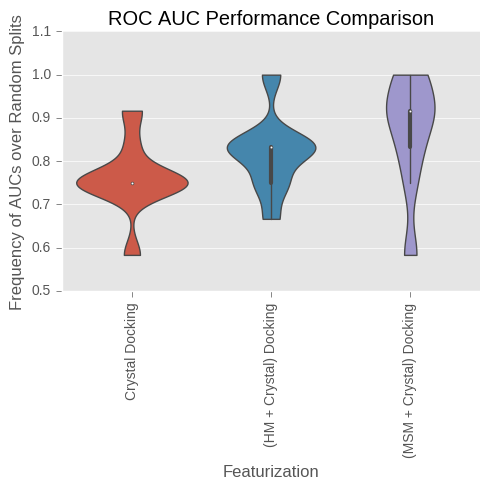

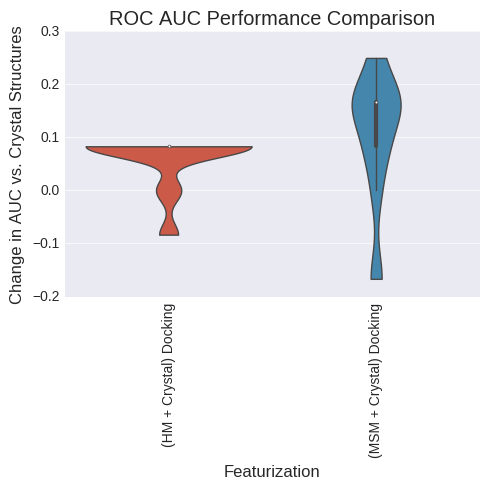

analyzing Recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.927778          0.000000   
(HM + Crystal) Docking     0.938889          0.011111   
(MSM + Crystal) Docking    0.905556         -0.022222   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.132633487545, 0.342210097576)  
(MSM + Crystal) Docking  (0.231374407182, 0.468536212887)  


ValueError: list.remove(x): x not in list

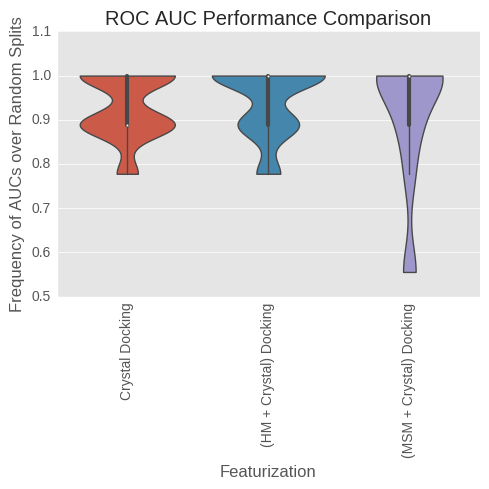

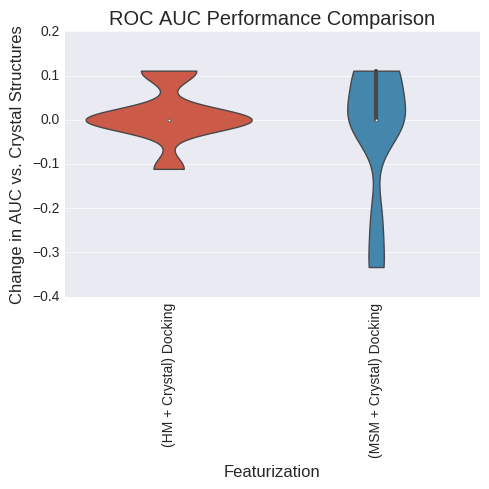

analyzing precision:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.793500          0.000000   
(HM + Crystal) Docking     0.848909          0.055409   
(MSM + Crystal) Docking    0.914000          0.120500   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking     (0.6687668635, 0.875145137625)  
(MSM + Crystal) Docking  (0.808682796607, 0.960296239466)  


ValueError: list.remove(x): x not in list

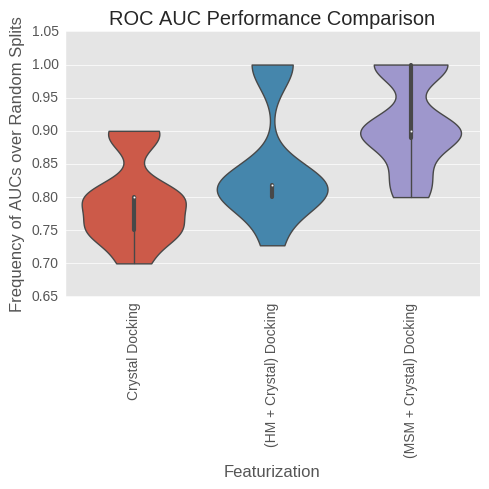

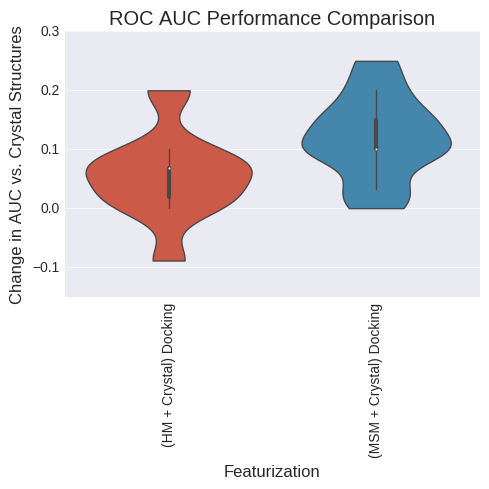

analyzing fdr:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.206500          0.000000   
(HM + Crystal) Docking     0.151091         -0.055409   
(MSM + Crystal) Docking    0.086000         -0.120500   

                                          Sign Test 99% CI  
Crystal Docking                                   (0, 0.0)  
(HM + Crystal) Docking   (0.0397037605337, 0.191317203393)  
(MSM + Crystal) Docking             (0.0, 0.0622206877158)  


ValueError: list.remove(x): x not in list

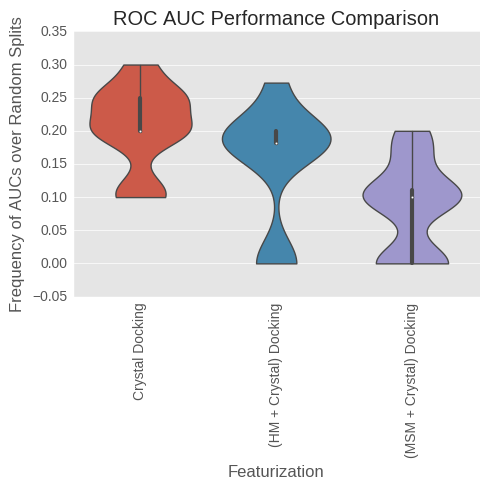

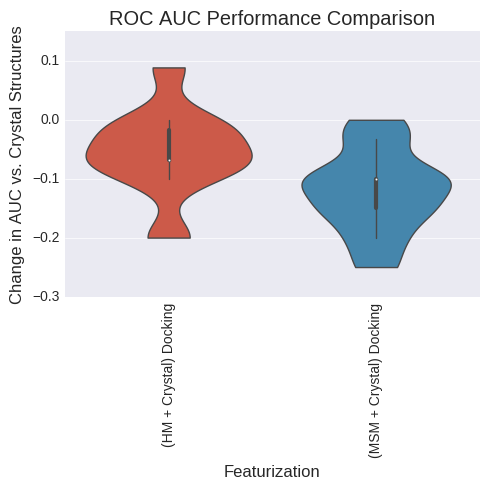

analyzing Recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.927778          0.000000   
(HM + Crystal) Docking     0.938889          0.011111   
(MSM + Crystal) Docking    0.905556         -0.022222   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.132633487545, 0.342210097576)  
(MSM + Crystal) Docking  (0.231374407182, 0.468536212887)  


ValueError: list.remove(x): x not in list

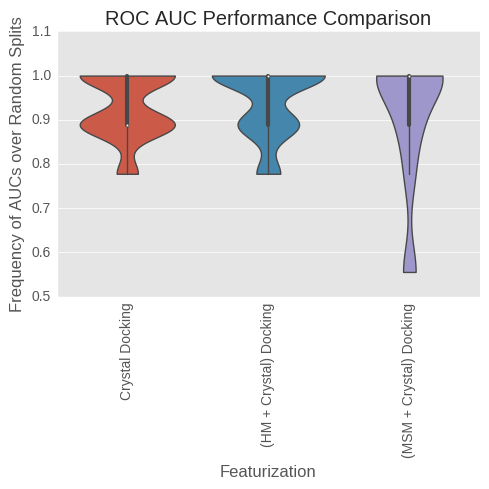

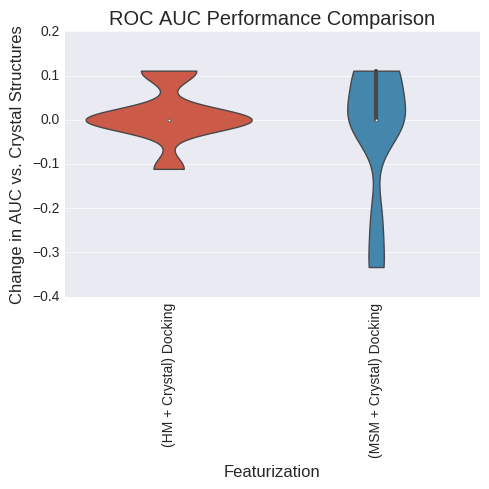

analyzing precision:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.793500          0.000000   
(HM + Crystal) Docking     0.848909          0.055409   
(MSM + Crystal) Docking    0.914000          0.120500   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking     (0.6687668635, 0.875145137625)  
(MSM + Crystal) Docking  (0.808682796607, 0.960296239466)  


ValueError: list.remove(x): x not in list

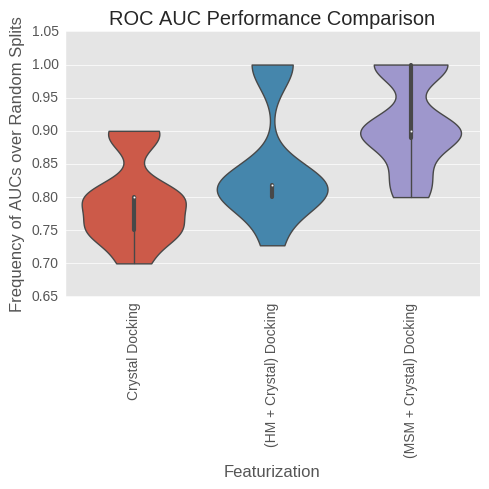

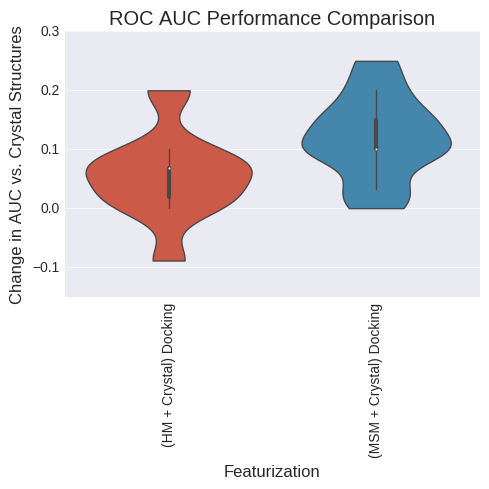

analyzing fdr:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.206500          0.000000   
(HM + Crystal) Docking     0.151091         -0.055409   
(MSM + Crystal) Docking    0.086000         -0.120500   

                                          Sign Test 99% CI  
Crystal Docking                                   (0, 0.0)  
(HM + Crystal) Docking   (0.0397037605337, 0.191317203393)  
(MSM + Crystal) Docking             (0.0, 0.0622206877158)  


ValueError: list.remove(x): x not in list

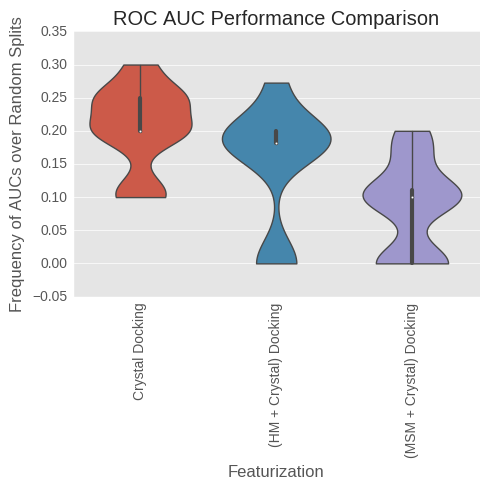

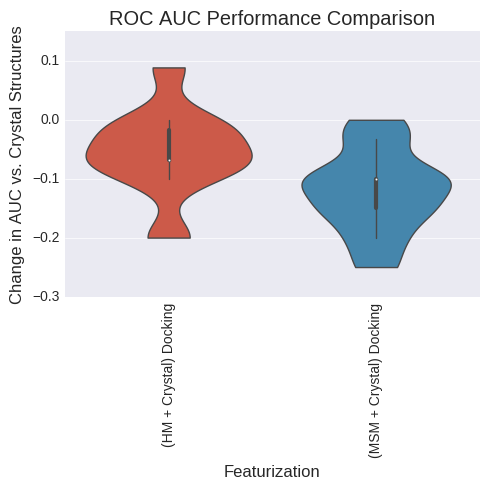

analyzing class B ROC AUC:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.739630          0.000000   
(HM + Crystal) Docking     0.793704          0.054074   
(MSM + Crystal) Docking    0.892963          0.153333   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.531463787113, 0.768625592818)  
(MSM + Crystal) Docking   (0.63606937983, 0.851575862558)  


ValueError: list.remove(x): x not in list

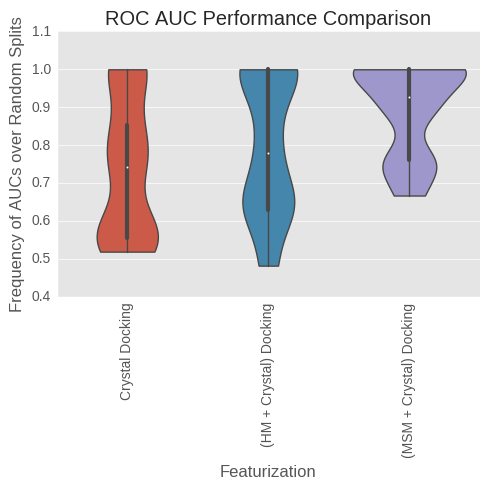

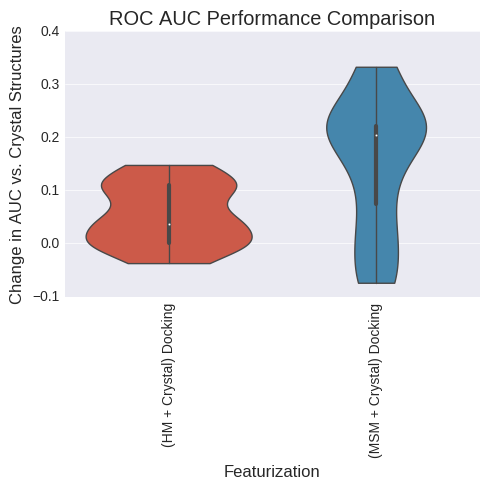

analyzing ROC AUC:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.739630          0.000000   
(HM + Crystal) Docking     0.793704          0.054074   
(MSM + Crystal) Docking    0.892963          0.153333   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.531463787113, 0.768625592818)  
(MSM + Crystal) Docking   (0.63606937983, 0.851575862558)  


ValueError: list.remove(x): x not in list

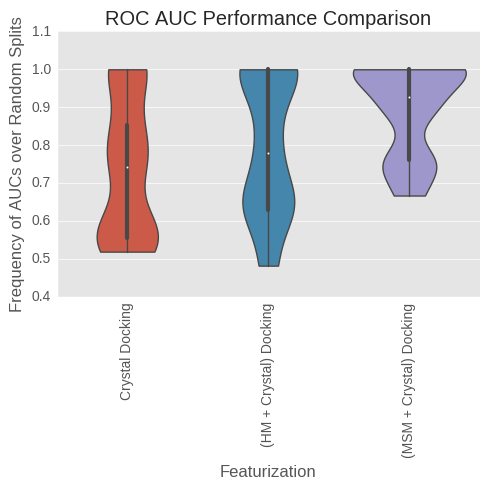

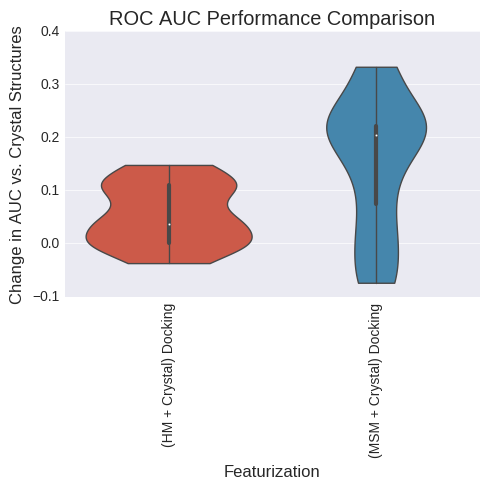

analyzing BedROC
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.888522          0.000000   
(HM + Crystal) Docking     0.746177         -0.142346   
(MSM + Crystal) Docking    0.997245          0.108723   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.413165633404, 0.661856711579)  
(MSM + Crystal) Docking   (0.63606937983, 0.851575862558)  


ValueError: list.remove(x): x not in list

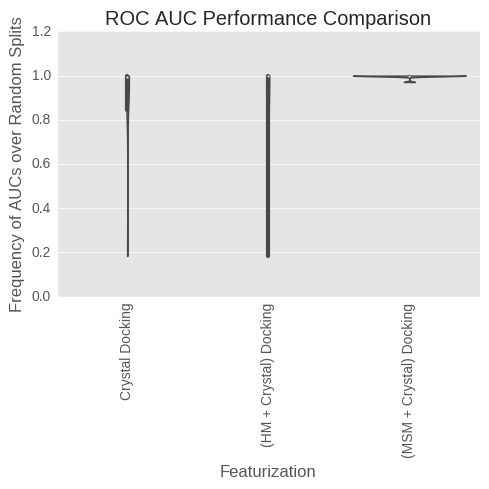

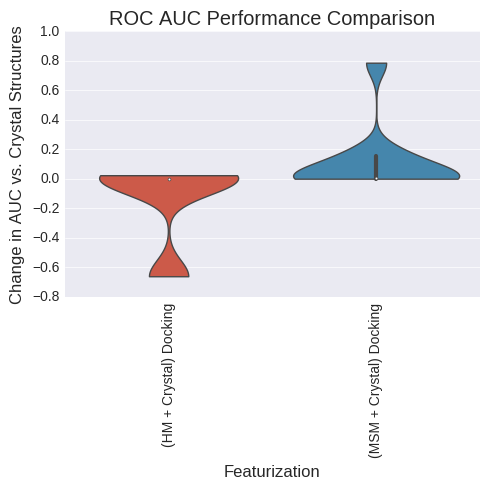

analyzing LogAUC
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.099132          0.000000   
(HM + Crystal) Docking     0.071789         -0.027342   
(MSM + Crystal) Docking    0.081048         -0.018084   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.222811316676, 0.458343717148)  
(MSM + Crystal) Docking  (0.338143288421, 0.586834366596)  


ValueError: list.remove(x): x not in list

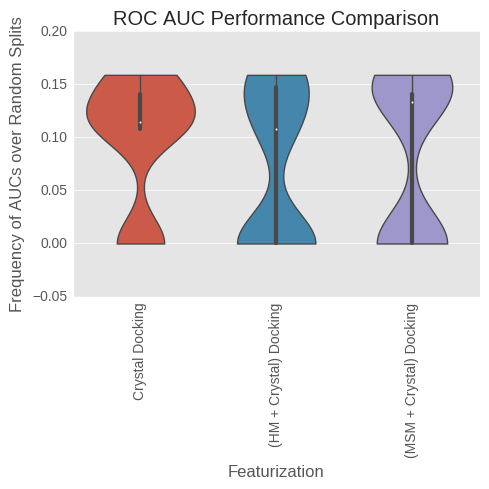

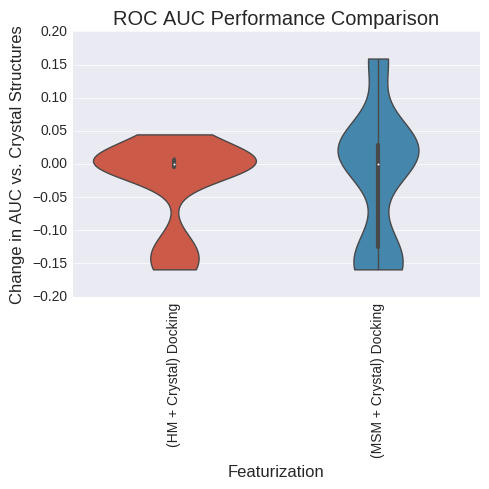

(1, 14)
(1, 14)


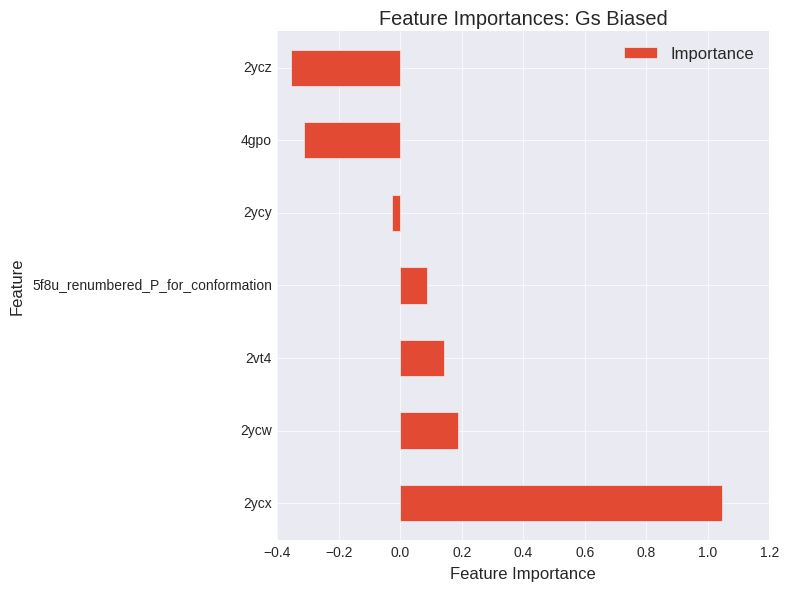

(1, 16)
(1, 16)


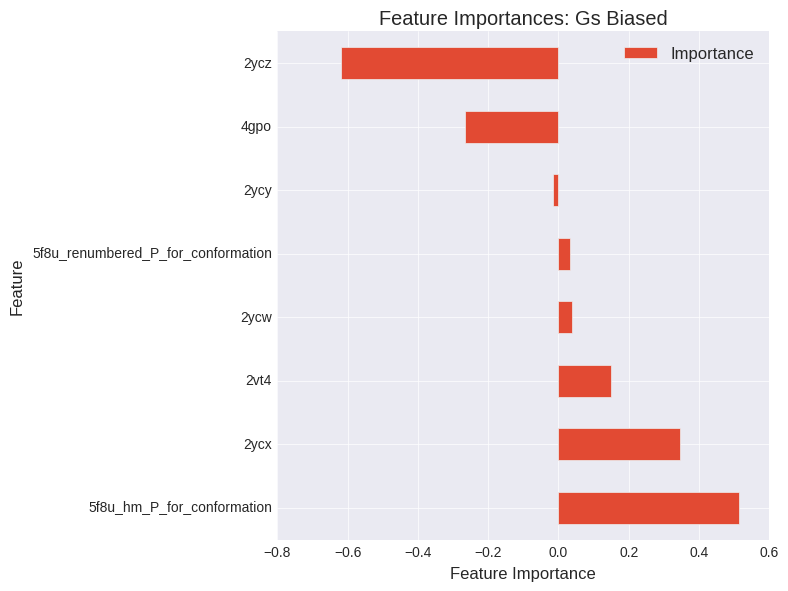

(1, 66)
(1, 66)


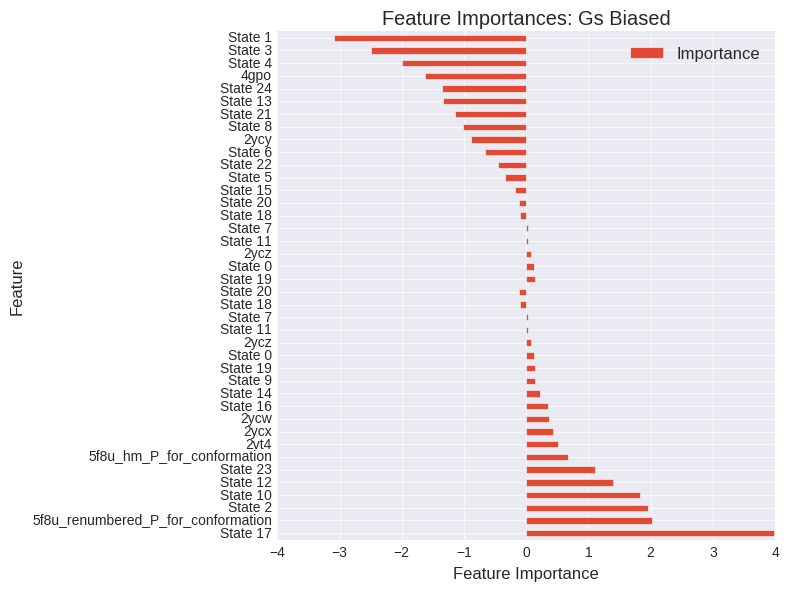

In [281]:
#LR, BRET +

importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], full_ligand_df.loc[model_agonists].index.values, analysis_dir,
                                                                ["Balanced", "Gs Biased", "Balanced Agonist", "Non-Binder"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([H_df.loc[model_agonists].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

analyzing precision at full recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.840682          0.000000   
(HM + Crystal) Docking     0.858818          0.018136   
(MSM + Crystal) Docking    0.857182          0.016500   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.222811316676, 0.458343717148)  
(MSM + Crystal) Docking  (0.222811316676, 0.458343717148)  


ValueError: list.remove(x): x not in list

analyzing threshold at full recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking             0.58104           0.00000   
(HM + Crystal) Docking      0.59551           0.01447   
(MSM + Crystal) Docking     0.52647          -0.05457   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.511241087644, 0.751337119796)  
(MSM + Crystal) Docking  (0.231374407182, 0.468536212887)  


ValueError: list.remove(x): x not in list

analyzing Accuracy:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.818333          0.000000   
(HM + Crystal) Docking     0.846667          0.028333   
(MSM + Crystal) Docking    0.808333         -0.010000   

                                          Sign Test 99% CI  
Crystal Docking                                   (0, 0.0)  
(HM + Crystal) Docking    (0.231374407182, 0.468536212887)  
(MSM + Crystal) Docking  (0.0592072768353, 0.228080445829)  


ValueError: list.remove(x): x not in list

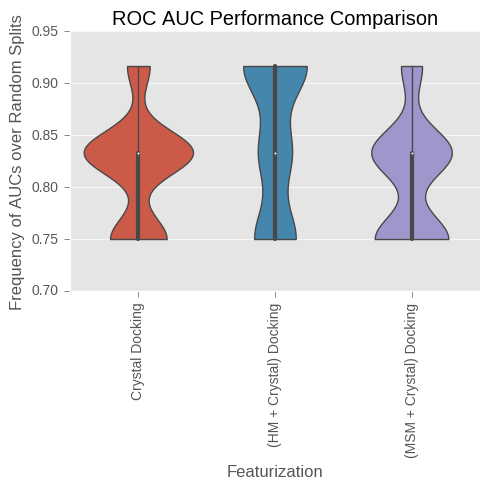

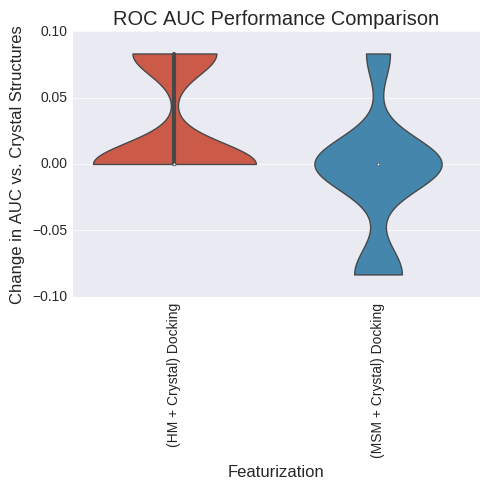

analyzing Recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.962222          0.000000   
(HM + Crystal) Docking     0.986667          0.024444   
(MSM + Crystal) Docking    0.950000         -0.012222   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.132633487545, 0.342210097576)  
(MSM + Crystal) Docking  (0.132633487545, 0.342210097576)  


ValueError: list.remove(x): x not in list

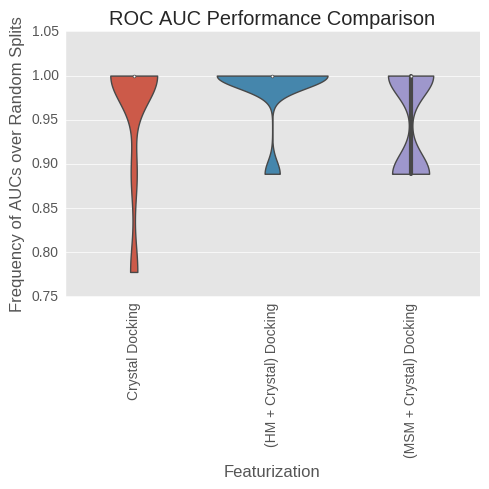

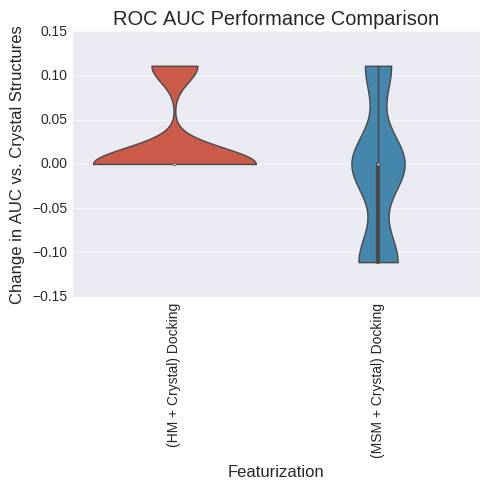

analyzing precision:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.836434          0.000000   
(HM + Crystal) Docking     0.847364          0.010929   
(MSM + Crystal) Docking    0.830348         -0.006086   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.132633487545, 0.342210097576)  
(MSM + Crystal) Docking    (0.124854862375, 0.3312331365)  


ValueError: list.remove(x): x not in list

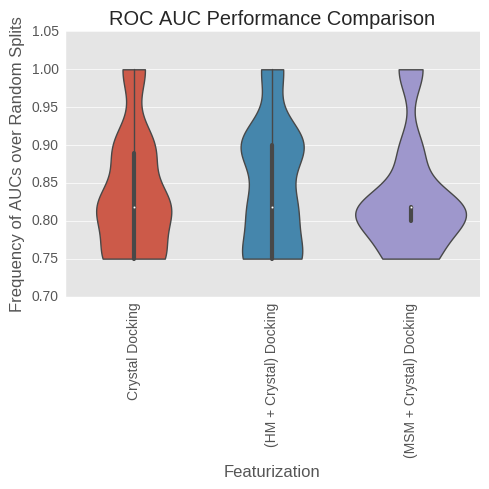

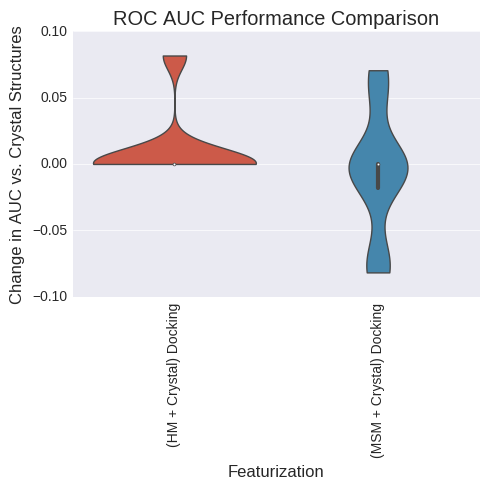

analyzing fdr:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.163566          0.000000   
(HM + Crystal) Docking     0.152636         -0.010929   
(MSM + Crystal) Docking    0.169652          0.006086   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking             (0.0, 0.0622206877158)  
(MSM + Crystal) Docking  (0.231374407182, 0.468536212887)  


ValueError: list.remove(x): x not in list

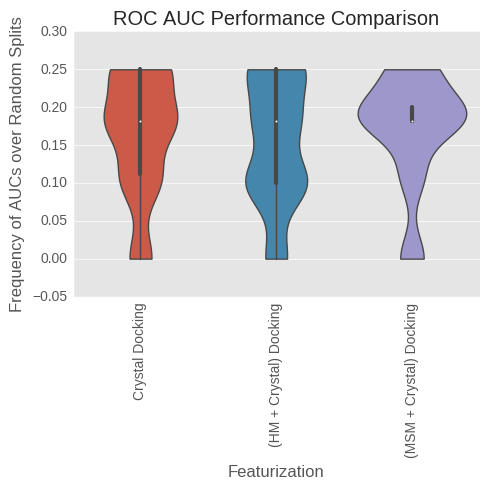

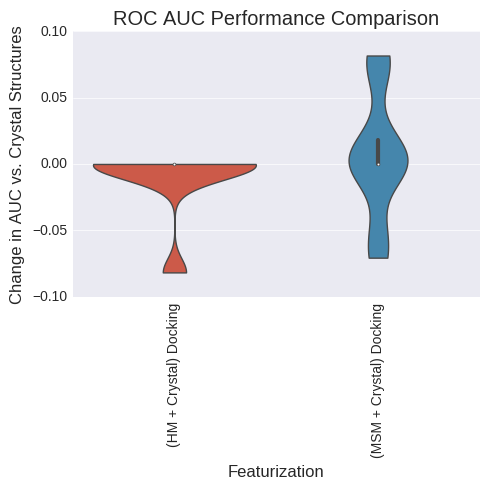

analyzing Recall:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.962222          0.000000   
(HM + Crystal) Docking     0.986667          0.024444   
(MSM + Crystal) Docking    0.950000         -0.012222   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.132633487545, 0.342210097576)  
(MSM + Crystal) Docking  (0.132633487545, 0.342210097576)  


ValueError: list.remove(x): x not in list

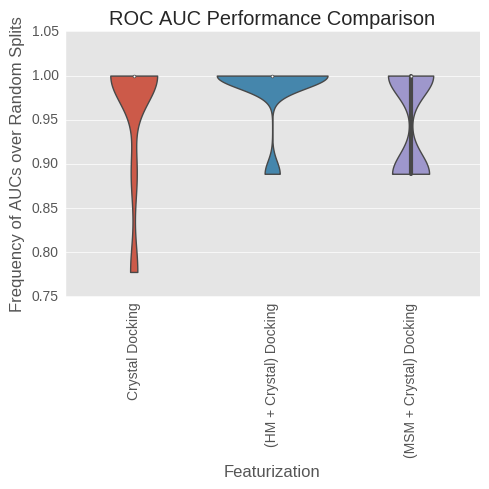

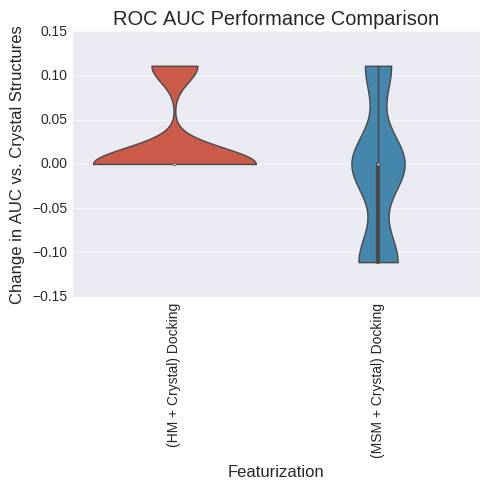

analyzing precision:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.836434          0.000000   
(HM + Crystal) Docking     0.847364          0.010929   
(MSM + Crystal) Docking    0.830348         -0.006086   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.132633487545, 0.342210097576)  
(MSM + Crystal) Docking    (0.124854862375, 0.3312331365)  


ValueError: list.remove(x): x not in list

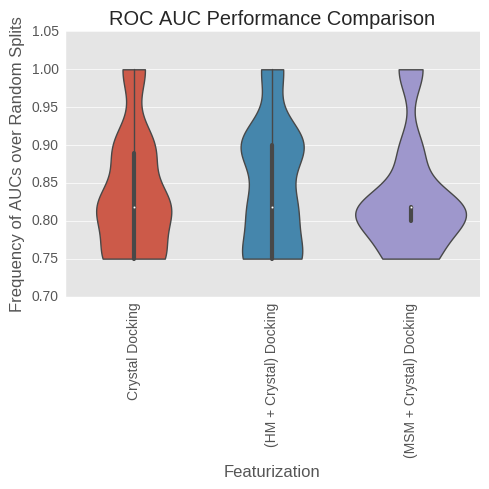

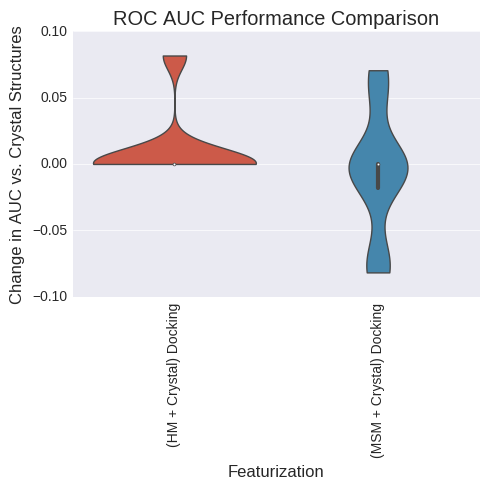

analyzing fdr:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.163566          0.000000   
(HM + Crystal) Docking     0.152636         -0.010929   
(MSM + Crystal) Docking    0.169652          0.006086   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking             (0.0, 0.0622206877158)  
(MSM + Crystal) Docking  (0.231374407182, 0.468536212887)  


ValueError: list.remove(x): x not in list

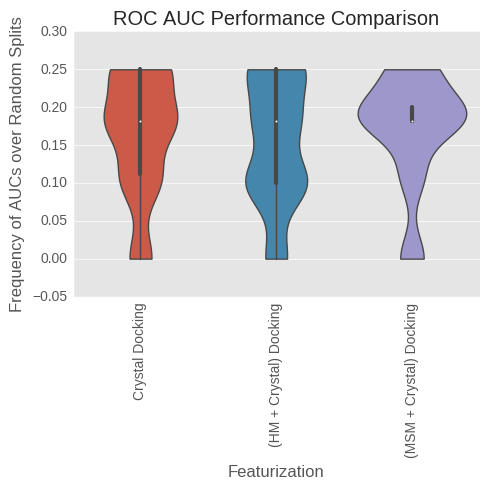

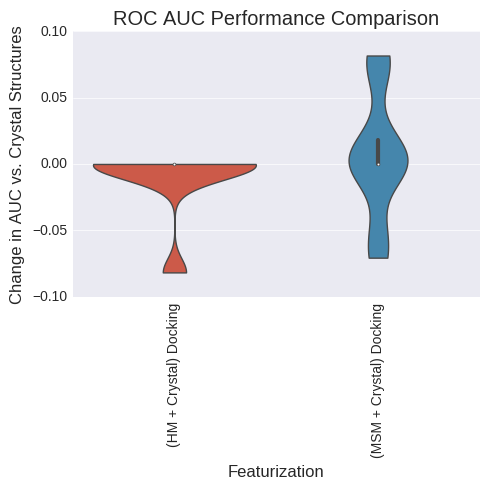

analyzing class B ROC AUC:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.706296          0.000000   
(HM + Crystal) Docking     0.752037          0.045741   
(MSM + Crystal) Docking    0.860185          0.153889   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking    (0.63606937983, 0.851575862558)  
(MSM + Crystal) Docking  (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

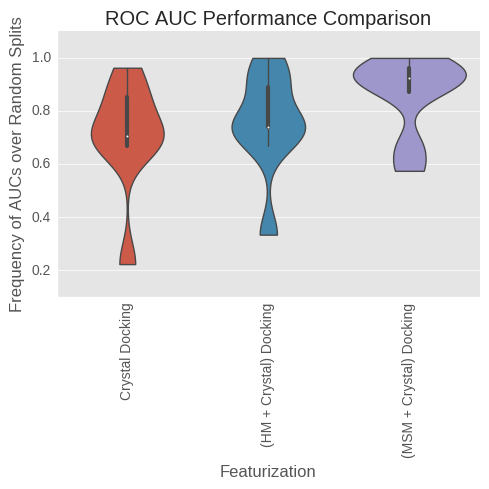

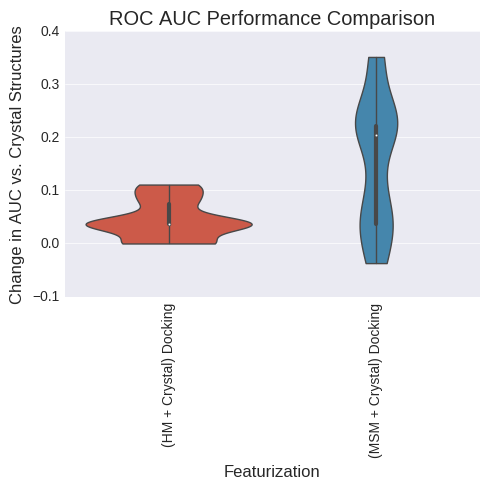

analyzing ROC AUC:
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.706296          0.000000   
(HM + Crystal) Docking     0.752037          0.045741   
(MSM + Crystal) Docking    0.860185          0.153889   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking    (0.63606937983, 0.851575862558)  
(MSM + Crystal) Docking  (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

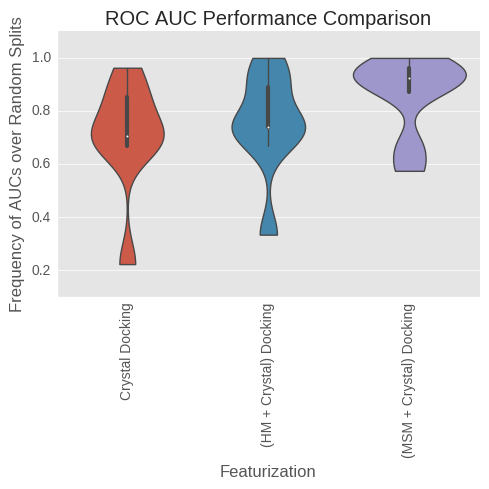

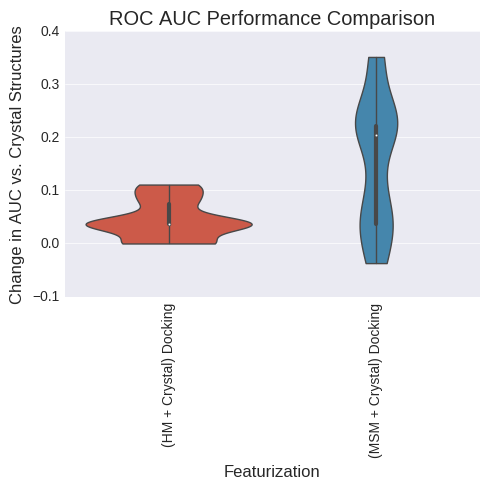

analyzing BedROC
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.859296          0.000000   
(HM + Crystal) Docking     0.875963          0.016667   
(MSM + Crystal) Docking    0.993002          0.133706   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.771919554171, 0.940792723165)  
(MSM + Crystal) Docking  (0.771919554171, 0.940792723165)  


ValueError: list.remove(x): x not in list

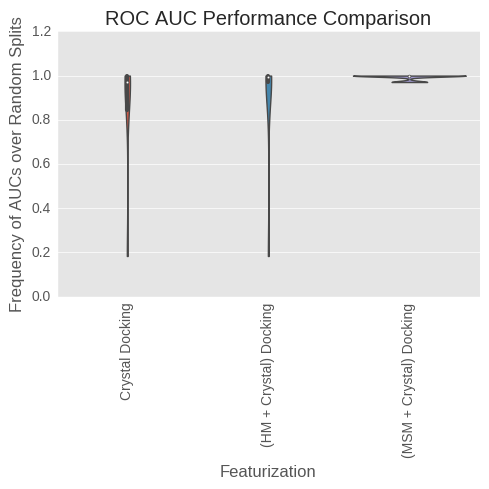

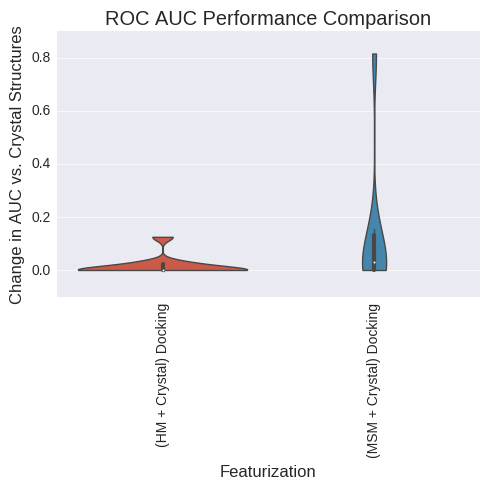

analyzing LogAUC
(100, 3)
                         Median AUC  Median delta AUC  \
Crystal Docking            0.139930          0.000000   
(HM + Crystal) Docking     0.106816         -0.033114   
(MSM + Crystal) Docking    0.099130         -0.040801   

                                         Sign Test 99% CI  
Crystal Docking                                  (0, 0.0)  
(HM + Crystal) Docking   (0.222811316676, 0.458343717148)  
(MSM + Crystal) Docking    (0.124854862375, 0.3312331365)  


ValueError: list.remove(x): x not in list

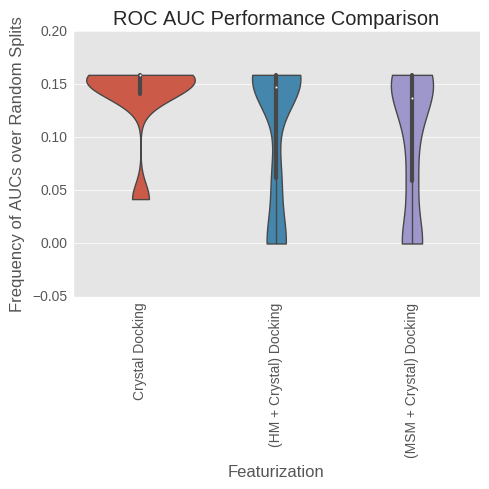

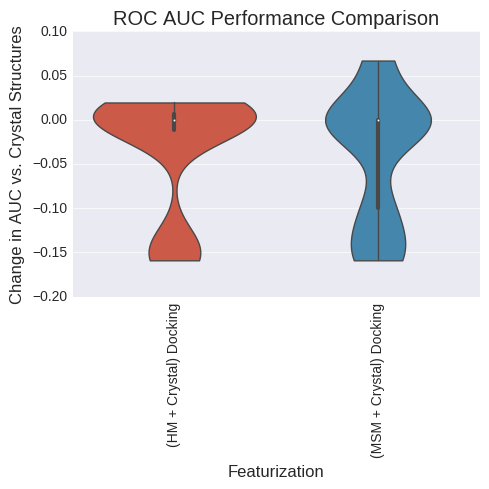

(14,)
(1, 14)


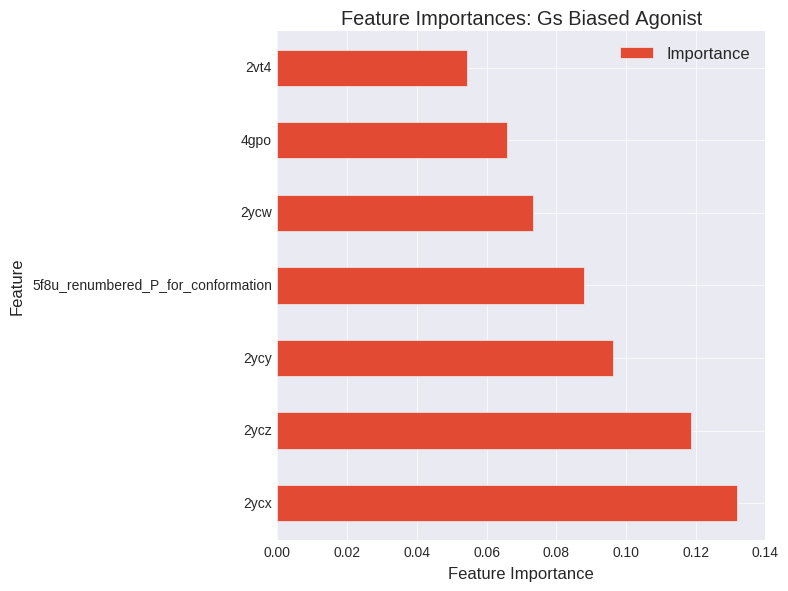

(16,)
(1, 16)


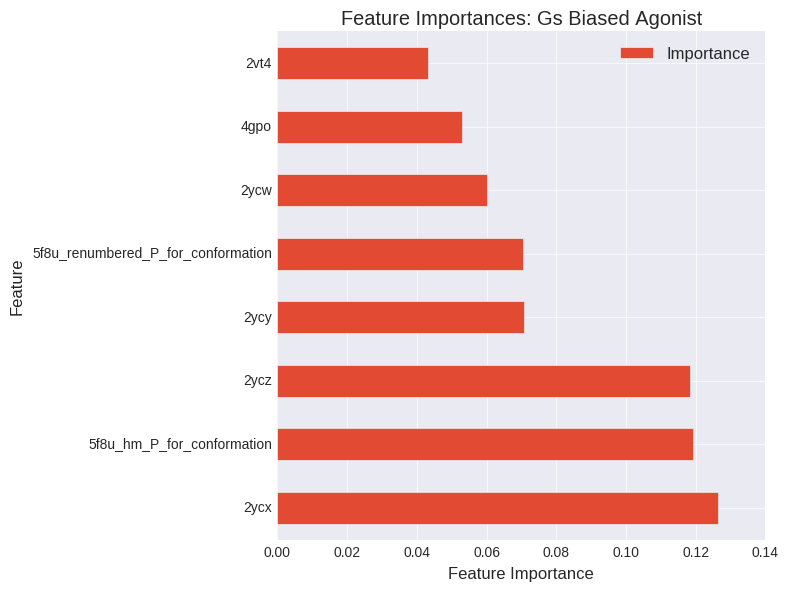

(66,)
(1, 66)


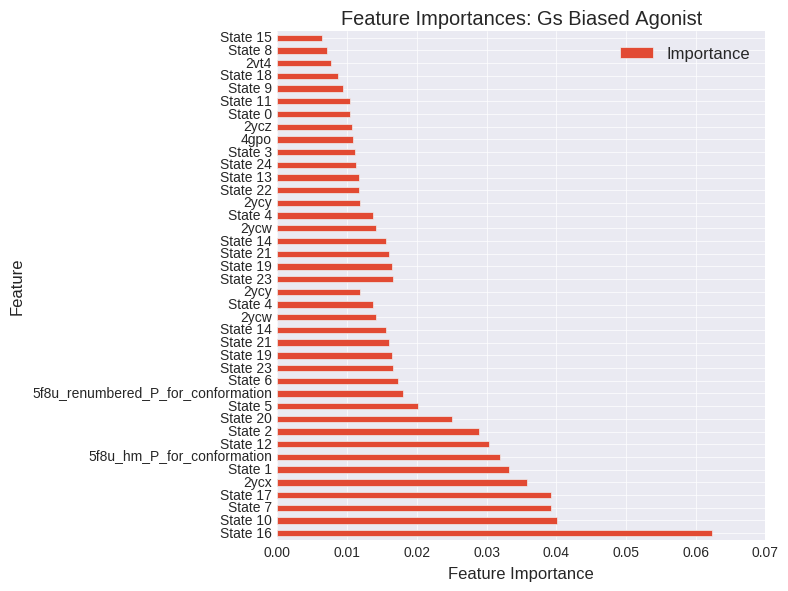

In [279]:
#RFR, BRET +

importance_dfs = analyze_multiclass_experiment(results_dict[save_name], 
                                                                feature_names,
                                                                [f.columns.values.tolist() for f in features], full_ligand_df.loc[model_agonists].index.values, analysis_dir,
                                                                ["Antagonist", "Gs Biased Agonist", "Balanced Agonist", "Non-Binder"], 
                                                                #["Gs Inactive", "Gs Active"], 
                                                               #["Arr Inactive", "Arr Active"],
                                               np.hstack([H_df.loc[model_agonists].values]),
                                                               #["Gs Inactive", "Gs Partial Active", "Gs Full Active"], 
                                              remake=False, fxn=np.mean)

In [48]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [44]:
list(results_dict[save_name].keys())

['Crystal Docking',
 'precisions_at_full_recall',
 'accuracies',
 'recall_means',
 'class_b_aucs',
 '(MSM + Crystal) Docking',
 'test_log_aucs',
 'class_b_recalls',
 'recalls',
 '(HM + Crystal) Docking',
 'fdrs',
 'precision_means',
 'class_b_fdrs',
 'fdr_means',
 'precisions',
 'feature_importances',
 'test_aucs',
 'class_b_precisions',
 'test_roc_aucs',
 'thresholds_at_full_recall',
 'bedrocs']

In [196]:
#model = results_dict[save_name]['Crystal Docking'][0]
model = results_dict[save_name]['(MSM + Crystal) Docking'][0]

y_proba =model.predict_proba(X_df.values)
#aff_eff_test_df = pd.DataFrame(y_proba, index=X_df.index, columns=["P(Balanced Agonist)", "P(Gs Biased Agonist)"]).sort("P(Gs Biased Agonist)", ascending=False, inplace=False)
aff_eff_test_df = pd.DataFrame(y_proba, index=X_df.index, columns=["P(Antagonist)", "P(Agonist)"]).sort("P(Agonist)", ascending=False, inplace=False)





#y_proba =model.predict_proba(C_df.values)
#bias_test_df = pd.DataFrame(y_proba, index=C_df.index, columns=["class A", "class B"]).sort("class B", ascending=False, inplace=False)

In [197]:
aff_eff_test_df#.loc[["xamoterol_s", "xamoterol_r", "ro363", "std101d1"]]

,P(Antagonist),P(Agonist)
index,,
cid_951,0.004,0.996
cid_5403,0.005,0.995
cid_10443654,0.010,0.990
cid_23844,0.014,0.986
butaxamine,0.016,0.984
cid_10087493,0.016,0.984
cid_4086,0.017,0.983
cid_23843,0.022,0.978
cid_5241141,0.023,0.977


In [119]:
test_inactives = [n for n in mehrdad.loc[(mehrdad["class"] == 2.)].index.values.tolist() if n not in model_agonists and n in full_docking_df.index]
#test_inactives = []
test_actives = ["cid_155774"]
#test_actives = [n for n in mehrdad.loc[(mehrdad["class"] == 0.) | (mehrdad["class"] == 1.) | (mehrdad["class"] == 2.)].index.values.tolist() if n not in model_agonists and n in full_docking_df.index]
#test_actives = [n.lower() for n in bret_y_df.loc[bret_y_df["class"] == 1.].index.values.tolist()]


test_df = pd.DataFrame(np.array([0. for i in test_inactives] + [1. for j in test_actives]).reshape((-1,1)), index = test_inactives+test_actives)

print(test_inactives)
print(test_actives)

test_proba =  aff_eff_test_df.loc[test_inactives+test_actives].sort("P(Gs Biased Agonist)",inplace=False, ascending=False).dropna()
test_df = test_df.loc[test_proba.index]

#df = aff_eff_test_df.loc[[n for n in aff_eff_test_df.index.values if mehrdad.loc[n]["class"] != 3.]]
#df = aff_eff_test_df.loc[[n for n in aff_eff_test_df.index if n not in common_ligands and n in mehrdad.index]]# if n not in model_agonists]]# and n in mehrdad.index]]# and ("ks" in n or "std" in n)]]# and "ks" in n.lower()]] in n



['ksn01014', 'ksn01017', 'ksn01018', 'ks01502', 'ks01504', 'ks01509', 'ks01515']
['cid_155774']


KeyError: 'P(Gs Biased Agonist)'

In [125]:
mehrdad["class"]

cid_3019        0.0
cid_7436        0.0
cid_838         0.0
cid_3343        0.0
cid_3609        0.0
cid_951         0.0
ksn01014        2.0
ksn01017        2.0
ksn01018        2.0
ksn010114       1.0
ksn010115       1.0
ksn010126       1.0
ks01502         2.0
ks01504         2.0
ks01509         2.0
ks01515         2.0
ks01501         1.0
ks01503         1.0
ks01506         1.0
ks01507         1.0
ks01510         1.0
ks01511         1.0
ksn010118       1.0
std101c4        1.0
cid_313         3.0
cid_2405        3.0
cid_3682        3.0
cid_2685        3.0
cid_2369        3.0
cid_2249        3.0
cid_18026       3.0
cid_3869        3.0
cid_4883        3.0
cid_4930        3.0
cid_4946        3.0
cid_313         3.0
cid_5478        3.0
cid_3152        3.0
cid_5732        3.0
cid_3100        3.0
cid_3689        3.0
cid_3162        3.0
cid_4614        3.0
cid_4848        3.0
cid_71771       3.0
cid_1981        3.0
cid_2554        3.0
sulfadizaine    3.0
cid_4539        3.0
cid_47964       3.0


In [161]:
full_ligand_df

,class
index,
cid_7436,1.0
cid_10443654,1.0
cid_161394,0.0
cid_2083,1.0
cid_2119,1.0
cid_2249,0.0
cid_2405,0.0
cid_18026,0.0
cid_5606,1.0


In [198]:
test_inactives = list(set([n for n in mehrdad.loc[mehrdad["class"] == 3.].index.values.tolist() + ["cid_%d" %c for c in other_inactives] + full_ligand_df.loc[full_ligand_df["class"]==0.].index.values.tolist() if n not in model_agonists and n in full_docking_df.index]))
test_actives = list(set([n for n in mehrdad.loc[(mehrdad["class"] == 1.) | (mehrdad["class"] == 2.)].index.values.tolist() + full_ligand_df.loc[full_ligand_df["class"]==1.].index.values.tolist() if n not in model_agonists and n in full_docking_df.index]))


test_df = pd.DataFrame(np.array([0. for i in test_inactives] + [1. for j in test_actives]).reshape((-1,1)), index = test_inactives+test_actives)

print(test_inactives)
print(test_actives)

test_proba =  aff_eff_test_df.loc[test_inactives+test_actives].sort("P(Agonist)",inplace=False, ascending=False).dropna()
test_df = test_df.loc[test_proba.index]

#df = aff_eff_test_df.loc[[n for n in aff_eff_test_df.index.values if mehrdad.loc[n]["class"] != 3.]]
#df = aff_eff_test_df.loc[[n for n in aff_eff_test_df.index if n not in common_ligands and n in mehrdad.index]]# if n not in model_agonists]]# and n in mehrdad.index]]# and ("ks" in n or "std" in n)]]# and "ks" in n.lower()]] in n


['cid_5732', 'cid_2554', 'cid_3152', 'cid_47964', 'cid_4848', 'cid_2685', 'cid_2369', 'cid_4614', 'sulfadizaine', 'cid_3689', 'cid_1978', 'cid_3100', 'cid_71771', 'cid_59768', 'cid_313', 'cid_4539', 'cid_3162', 'cid_4171', 'cid_9966051', 'cid_1981']
['ks01515', 'ksn010126', 'ksn01017', 'ksn01014', 'ksn01018', 'ks01510', 'ksn010115', 'ks01509', 'std101c4', 'ks01501', 'ksn010118', 'ks01503', 'ks01511', 'ks01506', 'ks01504', 'ksn010114', 'ks01502']


In [199]:
test_proba

,P(Antagonist),P(Agonist)
index,,
ks01510,0.161,0.839
ks01501,0.164,0.836
ksn010118,0.167,0.833
ksn01014,0.178,0.822
ksn010126,0.187,0.813
ks01504,0.190,0.810
ks01506,0.243,0.757
ksn01018,0.272,0.728
ks01502,0.273,0.727


In [200]:
from sklearn.metrics import roc_auc_score, precision_score
roc_auc_score(convert_to_n_class(test_df.values[:,0]), test_proba)

0.91764705882352948

In [521]:
mehrdad

,Name,Label,Emax on G-Protein,Emax on B-arrestin,Reference,action,class
cid_3779,Isoproterenol,Full agonist/unbiased,100,100,NaN,unbiased agonist,2.0
cid_7436,Adrenalone,Full agonist/unbiased,87,87,"Casella et al., 2011",unbiased agonist,2.0
cid_838,Epinephrine,Full agonist/unbiased,100,100,"Casella et al., 2011",unbiased agonist,2.0
cid_3343,Fenoterol,Full agonist/unbiased,81,87,"Casella et al., 2011",unbiased agonist,2.0
cid_3609,Hexoprenaline,Full agonist/unbiased,101,96,"Casella et al., 2011",unbiased agonist,2.0
cid_951,Norepinephrine,Full agonist/unbiased,100,95,"Casella et al., 2011",unbiased agonist,2.0
ksn01014,KSN01-01-4,Full agonist for G-protein/not tested in beta-...,99.95,NaN,NaN,unknown,1.0
ksn01017,KSN01-01-7,Full agonist for G-protein/not tested in beta-...,94.7,NaN,NaN,unknown,1.0
ksn01018,KSN01-01-8,Full agonist for G-protein/not tested in beta-...,107.1,NaN,NaN,unknown,1.0
ksn010114,KSN01-01-14,Full agonist for G-protein/biased for G-protein,95.7,No response,NaN,biased agonist,1.0


In [487]:
mehrdad.loc[n]["class"]

KeyError: 'the label [Cefadroxil ] is not in the [index]'

In [522]:
full_docking_df

,2vt4,2ycw,2ycx,2ycy,2ycz,4gpo,5f8u_hm_P_for_conformation,5f8u_renumbered_P_for_conformation,State 0,State 10,State 11,State 12,State 13,State 14,State 15,State 16,State 17,State 18,State 19,State 1,State 20,State 21,State 22,State 23,State 24,State 2,State 3,State 4,State 5,State 6,State 7,State 8,State 9
aceclofenac,5.62,5.60,5.93,5.40,6.06,5.11,6.03,6.15,4.10,4.32,6.69,5.08,3.20,5.73,4.70,6.38,5.02,3.71,2.98,5.14,5.07,5.30,4.62,6.25,5.80,4.69,6.19,5.82,4.76,4.55,3.82,5.83,4.81
acemetacin,6.31,6.18,6.33,6.66,7.08,3.38,3.50,7.02,5.85,4.10,5.75,6.04,5.58,5.37,4.04,4.66,4.46,6.20,5.18,5.52,6.03,6.54,6.34,5.80,5.18,4.20,7.28,5.57,4.98,4.31,4.76,5.93,4.73
adrenalone,6.65,5.95,7.03,5.97,5.90,5.71,7.34,6.24,6.62,6.18,5.60,6.90,5.84,6.32,6.64,6.78,6.07,6.32,6.69,5.39,6.58,6.18,6.28,5.07,6.12,6.70,6.56,6.01,5.89,4.54,7.57,7.78,6.94
atenolol,4.92,5.95,5.58,4.71,4.59,4.31,5.57,5.65,5.51,4.81,5.48,4.95,7.26,4.09,5.28,6.00,4.41,4.38,6.69,5.22,5.44,4.49,4.42,5.35,4.50,5.12,6.85,5.61,6.06,2.93,5.98,4.64,6.36
betaxolol,6.10,5.87,5.64,5.00,6.08,5.32,6.10,5.67,7.54,4.44,7.14,6.23,6.24,5.44,6.55,5.51,5.78,5.41,6.48,5.80,6.52,5.67,6.15,5.78,5.18,5.50,7.64,6.55,6.87,3.52,6.58,6.26,7.10
bisoprolol,6.63,6.38,6.09,5.72,6.10,5.63,5.34,5.76,7.00,5.60,5.04,6.11,7.07,6.31,6.76,4.84,5.89,6.78,7.20,6.40,5.86,5.38,6.38,5.23,5.54,5.34,7.79,6.02,5.97,3.29,6.23,6.25,7.33
butaxamine,7.09,7.11,8.14,7.11,6.87,7.91,8.12,7.48,7.19,7.33,7.76,7.38,7.59,7.13,7.59,8.19,7.45,6.70,7.62,6.60,8.21,6.98,7.82,6.59,7.09,6.71,7.85,6.55,6.94,5.39,8.49,6.62,7.28
captopril,5.75,4.90,6.00,5.01,5.27,5.16,7.64,5.35,4.92,5.46,5.07,5.31,5.31,4.64,5.32,5.27,5.34,5.77,5.28,4.82,5.15,5.12,5.00,6.00,5.00,4.46,5.36,5.52,5.37,5.66,4.71,5.60,4.31
cefadroxil,8.70,8.31,7.74,7.09,7.92,7.29,8.58,9.55,8.56,5.64,7.22,7.02,6.66,8.15,9.64,8.48,8.37,7.11,5.67,6.62,8.58,8.17,8.51,6.81,8.39,6.55,8.01,7.15,6.67,5.51,9.27,7.86,7.06
cgp20712a,9.15,7.65,9.19,6.85,8.70,6.35,8.06,9.27,9.07,7.11,8.37,7.87,8.44,8.64,9.63,8.22,6.66,7.30,7.99,7.92,8.12,8.95,8.54,8.70,8.92,7.26,8.73,7.73,8.29,5.34,8.08,9.23,7.77
